##Part 1


In [10]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import pickle

In [11]:
class DroneDeliveryEnv(gym.Env):
    def __init__(self, deterministic=True):
        super(DroneDeliveryEnv, self).__init__()

        # Environment configuration
        self.grid_size = 6
        self.deterministic = deterministic
        self.start_position = (0, 0)  # Starting point
        self.goal_position = (5, 5)  # Delivery point
        self.no_fly_zones = [(3, 3), (4, 2)]  # No-fly zones

        # Action space: [Up, Down, Left, Right, Pickup, Drop-off]
        self.action_space = spaces.Discrete(6)

        # Observation space: (x, y) drone's position
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size)
        ))

        self.drone_position = None
        self.has_package = False
        self.time_step = 0

        # Rewards
        self.rewards = {
            "step": -1,  # Reduce step penalty to encourage exploration
            "no_fly_zone": -20,
            "delivery": 20 , # Increase delivery reward to make learning faster
            "approach_goal": 5  # Encourage getting **closer** to the goal

        }

    def reset(self):
        self.drone_position = self.start_position
        self.has_package = False
        self.time_step = 0
        return self.drone_position

    def step(self, action):
        x, y = self.drone_position
        new_x, new_y = x, y

        # Movement actions
        if action == 0:  # Up
            new_x, new_y = x - 1, y
        elif action == 1:  # Down
            new_x, new_y = x + 1, y
        elif action == 2:  # Left
            new_x, new_y = x, y - 1
        elif action == 3:  # Right
            new_x, new_y = x, y + 1
        elif action == 4:  # Pickup
            if (x, y) == self.start_position:
                self.has_package = True
        elif action == 5:  # Drop-off
            if (x, y) == self.goal_position and self.has_package:
                reward = self.rewards["delivery"]
                return (new_x, new_y), reward, True, {}

        # Checking bounds
        if new_x < 0 or new_x >= self.grid_size or new_y < 0 or new_y >= self.grid_size:
            new_x, new_y = x, y

        # Stochastic movement
        if not self.deterministic:
            if np.random.uniform(0, 1) > 0.9:
                new_x, new_y = self._apply_random_drift(new_x, new_y)

        # Check for no-fly zone
        if (new_x, new_y) in self.no_fly_zones:
            reward = self.rewards["no_fly_zone"]
        else:
            reward = self.rewards["step"]

        # Encourage movement towards the goal
        if abs(new_x - self.goal_position[0]) + abs(new_y - self.goal_position[1]) < abs(x - self.goal_position[0]) + abs(y - self.goal_position[1]):
            reward += self.rewards["approach_goal"]  # Extra reward for getting closer


        self.drone_position = (new_x, new_y)
        self.time_step += 1
        done = False
        if self.time_step >= 50:
            done = True  # Terminate after max steps

        return self.drone_position, reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))

        for x, y in self.no_fly_zones:
            grid[x, y] = 3  # No-fly zone

        start_x, start_y = self.start_position
        goal_x, goal_y = self.goal_position
        drone_x, drone_y = self.drone_position

        grid[start_x, start_y] = 1  # Start point
        grid[goal_x, goal_y] = 2  # Goal point
        grid[drone_x, drone_y] = 4  # Drone's position

        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = plt.get_cmap("viridis", 5)
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=4)

        cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
        cbar.ax.set_yticklabels(['Fly Area', 'Start', 'Goal', 'No-fly Zone', 'Drone'])

        ax.set_xticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)

        for (i, j), label in np.ndenumerate(grid):
            if label == 1:
                ax.text(j, i, 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 2:
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 4:
                ax.text(j, i, 'D', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

        plt.title(f"Autonomous Drone Delivery (Timestep: {self.time_step})")
        plt.show()

    def _apply_random_drift(self, x, y):
        possible_moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        drift_x, drift_y = possible_moves[np.random.randint(0, 4)]
        new_x, new_y = x + drift_x, y + drift_y

        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            return new_x, new_y
        return x, y


Deterministic Environment:
State: (0, 0), Reward: -1


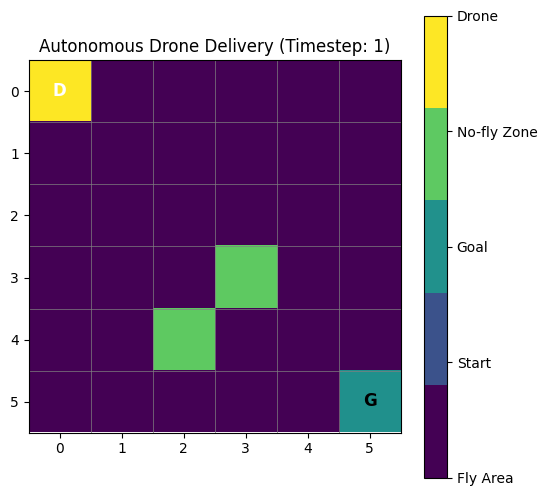

State: (0, 0), Reward: -1


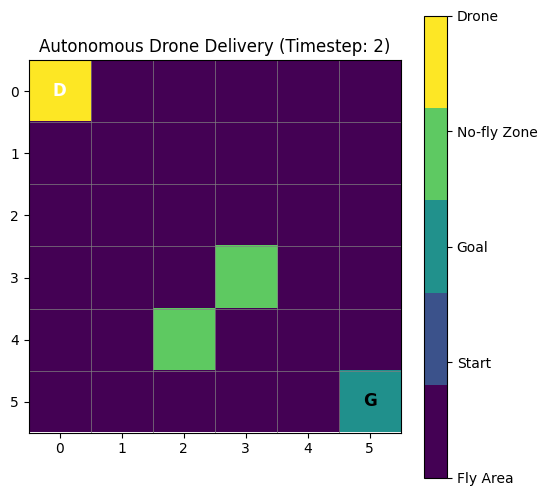

State: (0, 1), Reward: 4


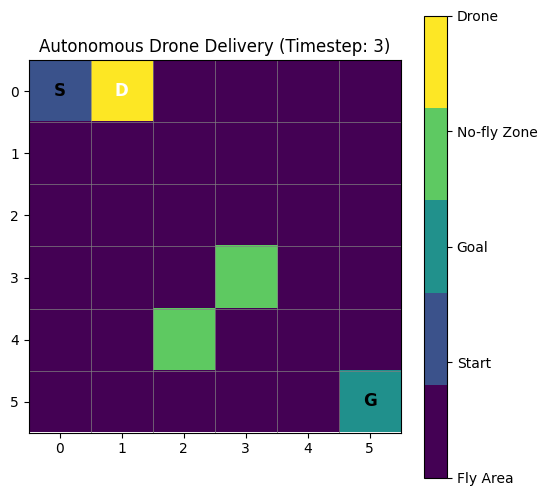

State: (0, 1), Reward: -1


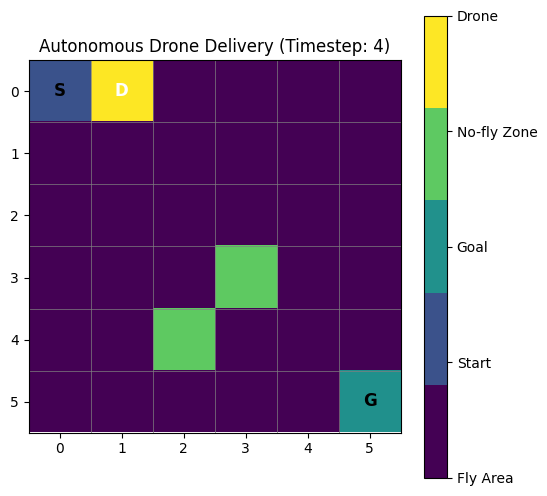

State: (1, 1), Reward: 4


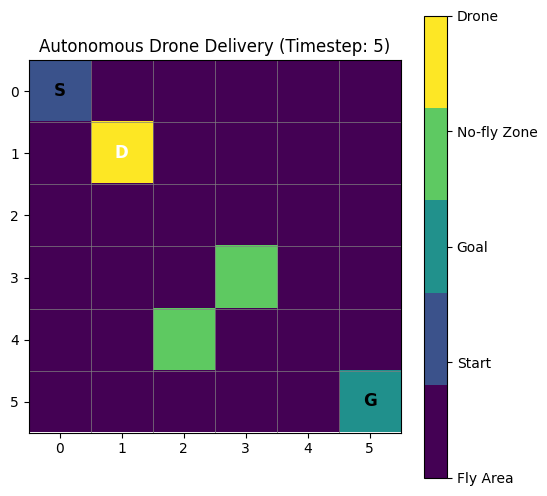

State: (1, 1), Reward: -1


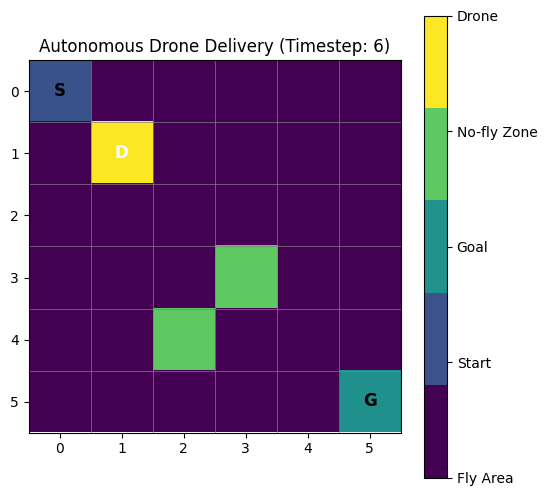

State: (1, 2), Reward: 4


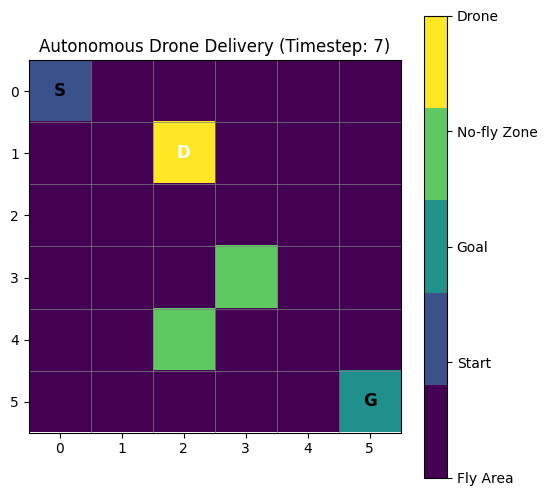

State: (1, 2), Reward: -1


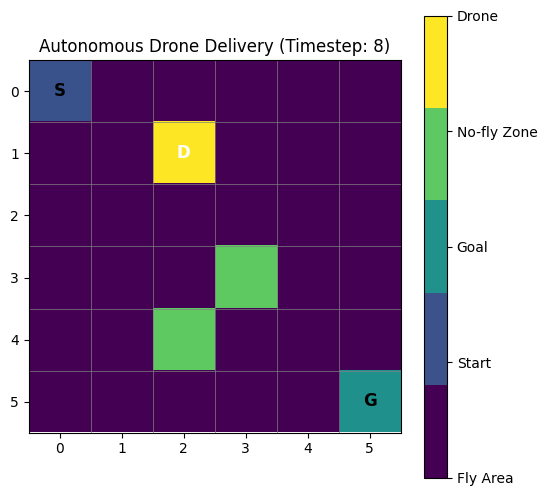

State: (1, 2), Reward: -1


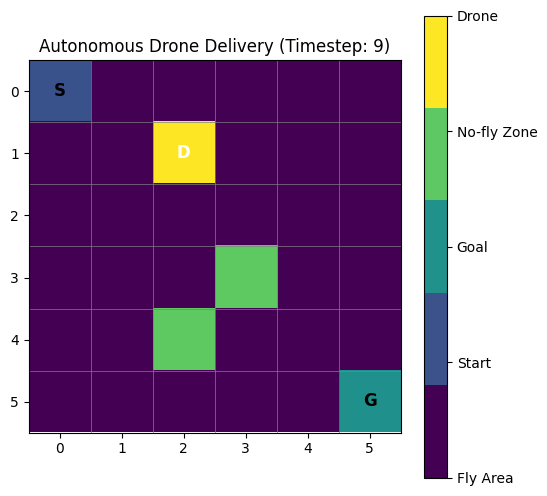

State: (2, 2), Reward: 4


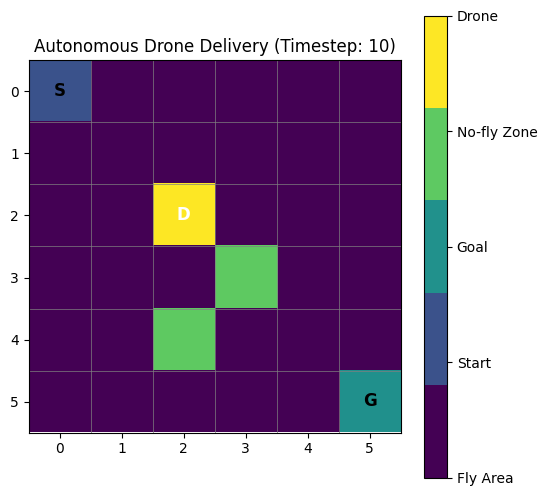

State: (2, 2), Reward: -1


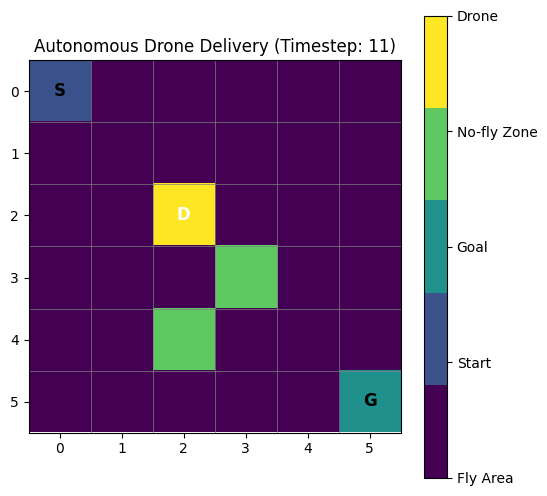

State: (3, 2), Reward: 4


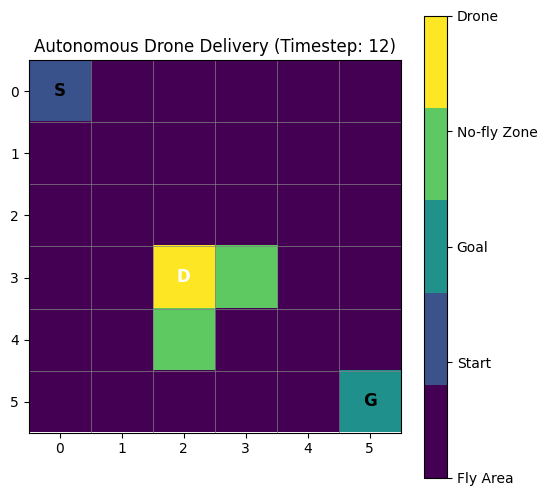

State: (3, 3), Reward: -15


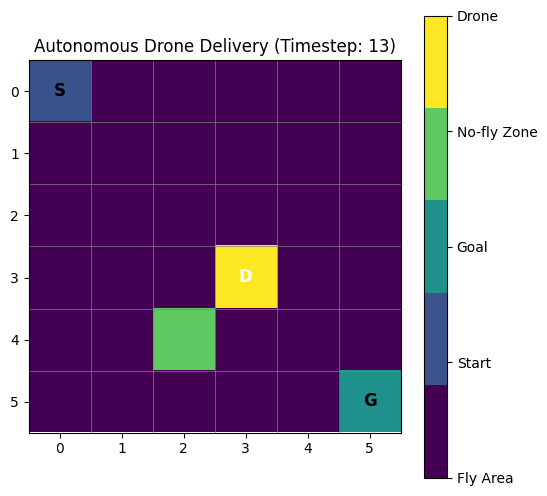

State: (3, 3), Reward: -20


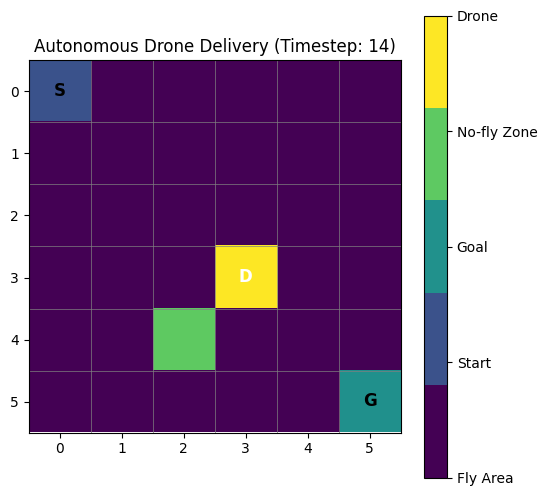

State: (3, 2), Reward: -1


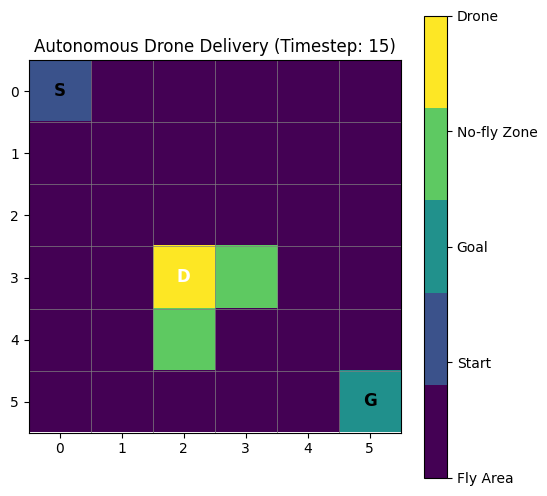

State: (2, 2), Reward: -1


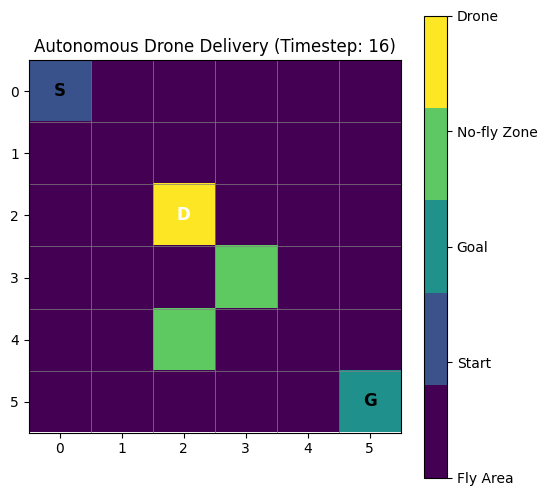

State: (2, 2), Reward: -1


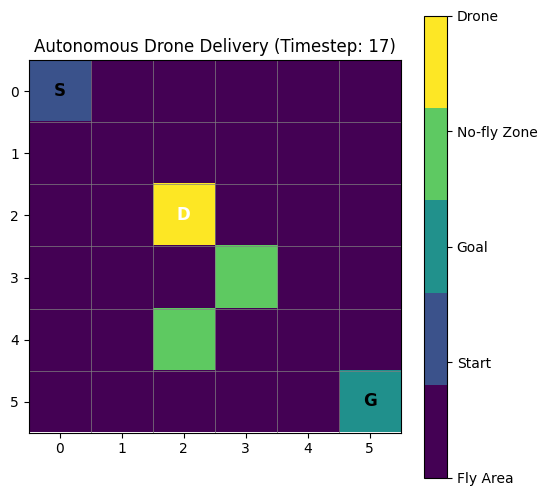

State: (3, 2), Reward: 4


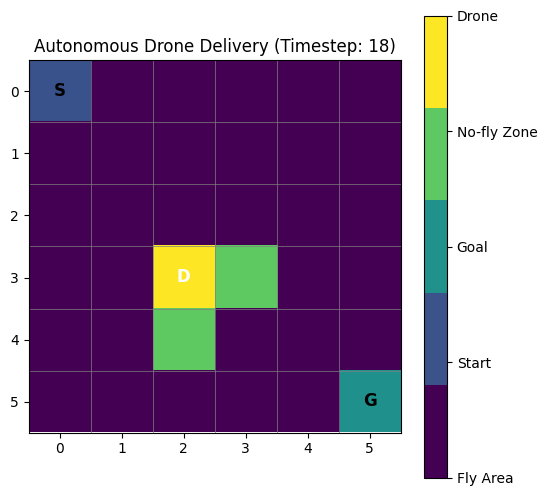

State: (2, 2), Reward: -1


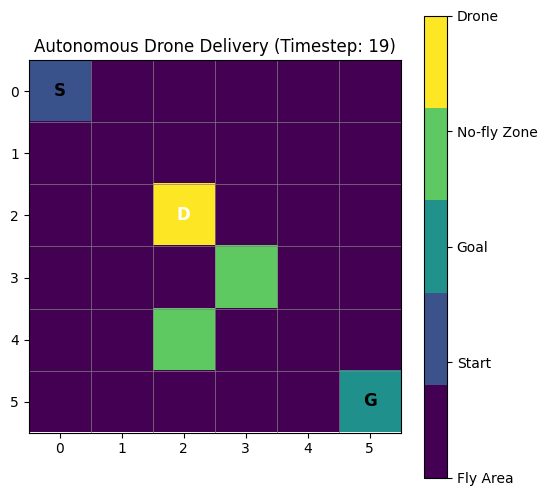

State: (2, 2), Reward: -1


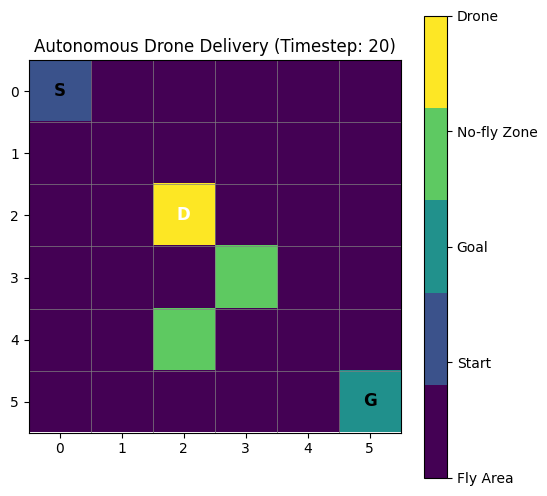

State: (3, 2), Reward: 4


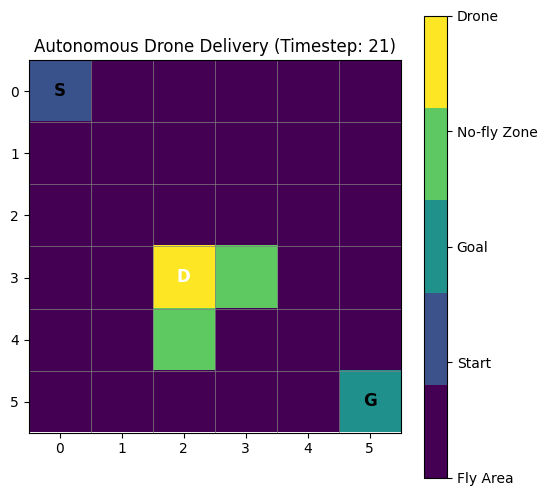

State: (4, 2), Reward: -15


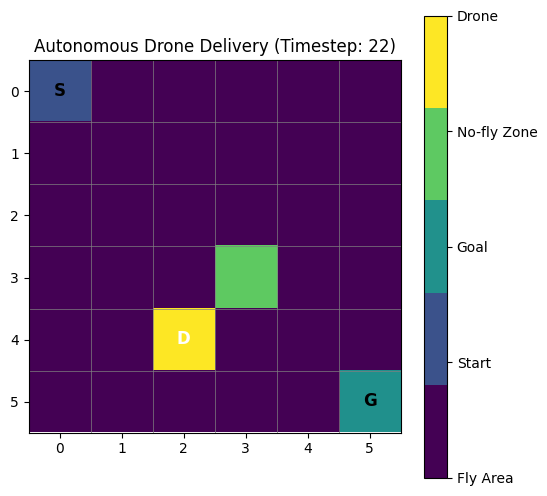

State: (4, 2), Reward: -20


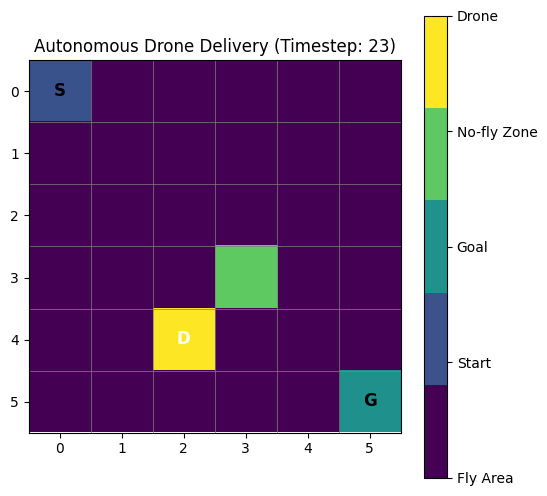

State: (3, 2), Reward: -1


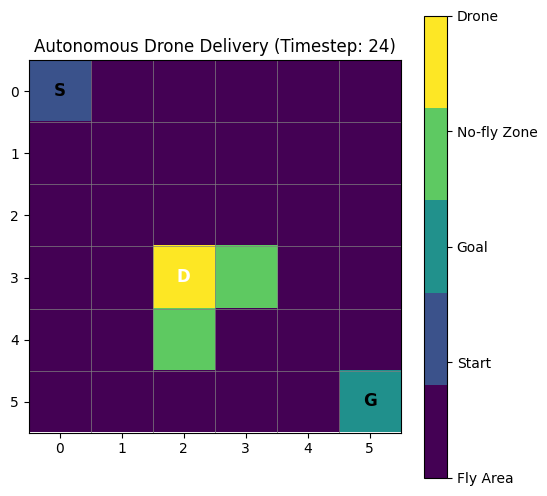

State: (3, 2), Reward: -1


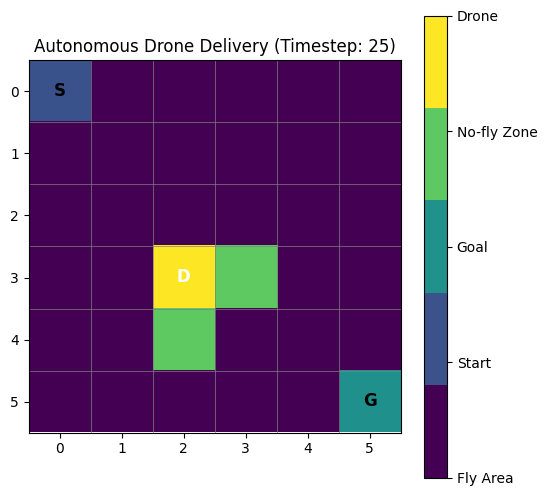

State: (3, 2), Reward: -1


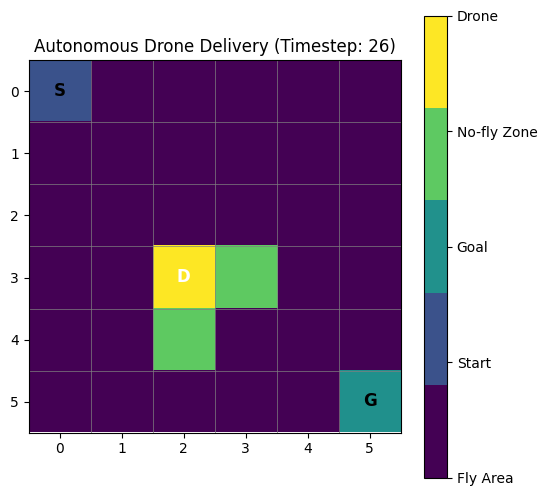

State: (3, 1), Reward: -1


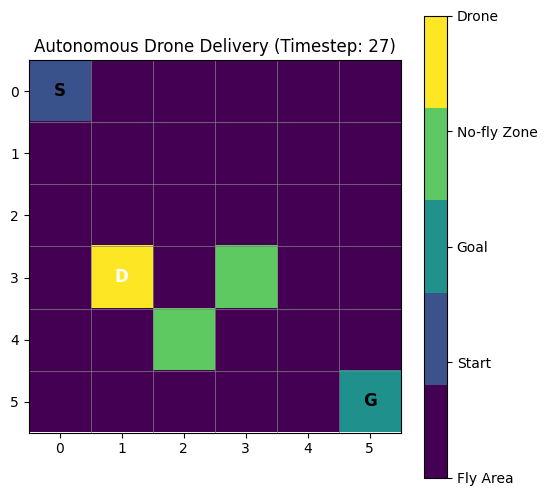

State: (2, 1), Reward: -1


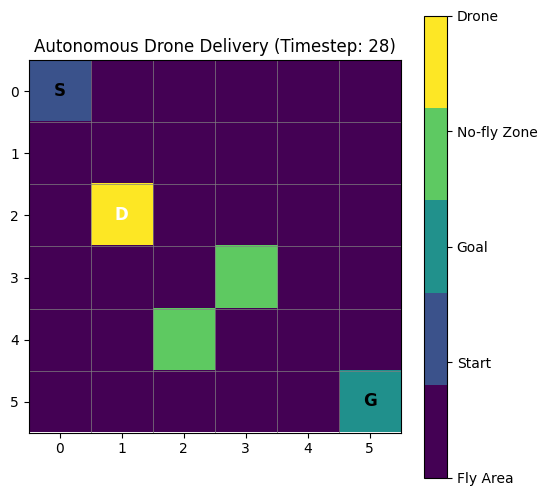

State: (1, 1), Reward: -1


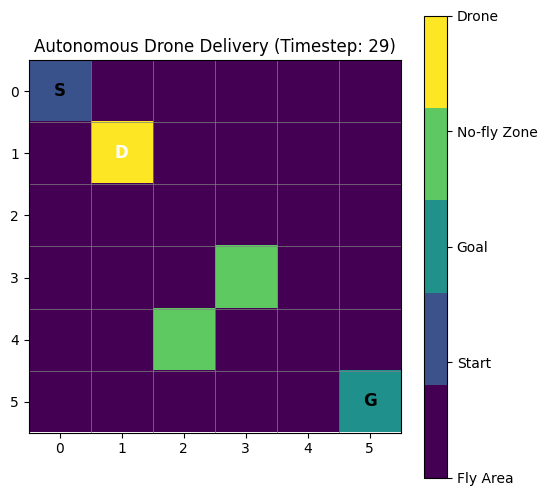

State: (2, 1), Reward: 4


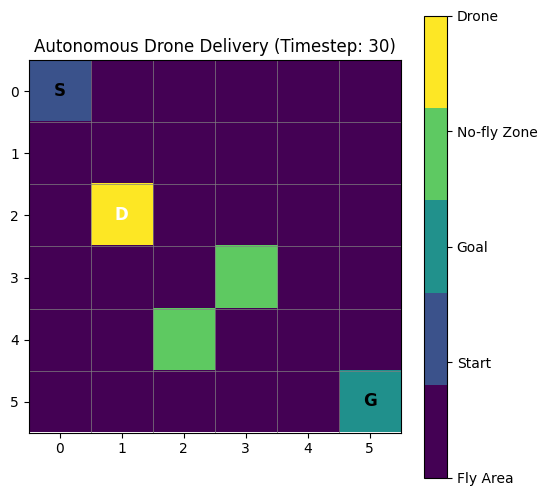


Stochastic Environment:
State: (1, 0), Reward: 4


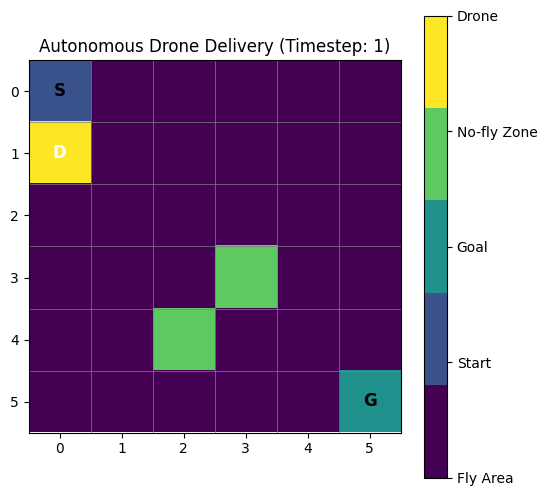

State: (1, 0), Reward: -1


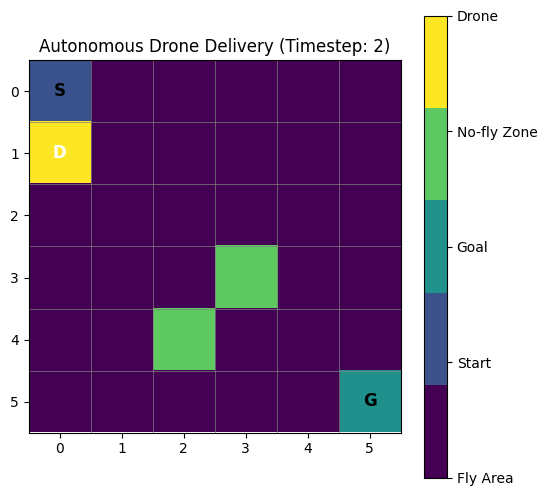

State: (1, 0), Reward: -1


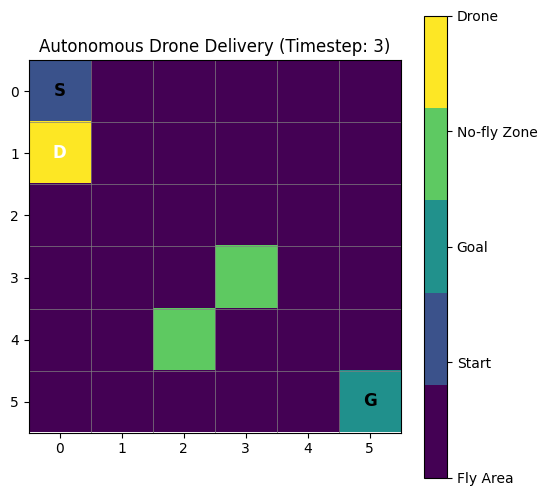

State: (2, 0), Reward: 4


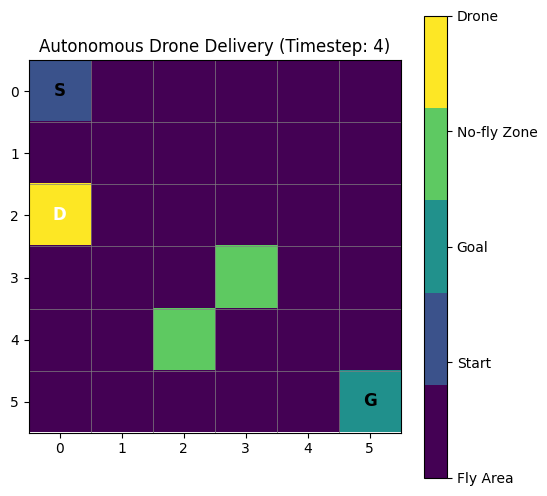

State: (3, 0), Reward: 4


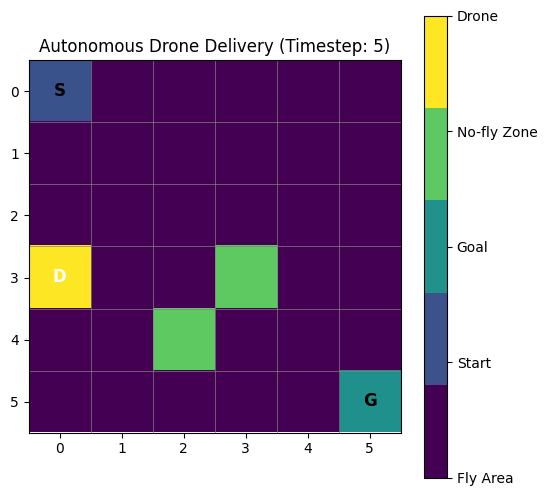

State: (3, 0), Reward: -1


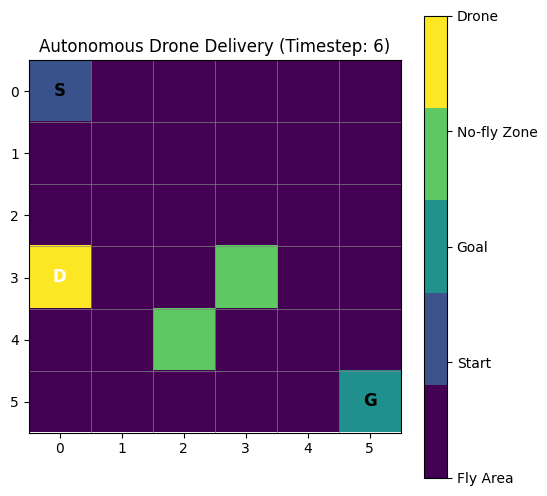

State: (3, 0), Reward: -1


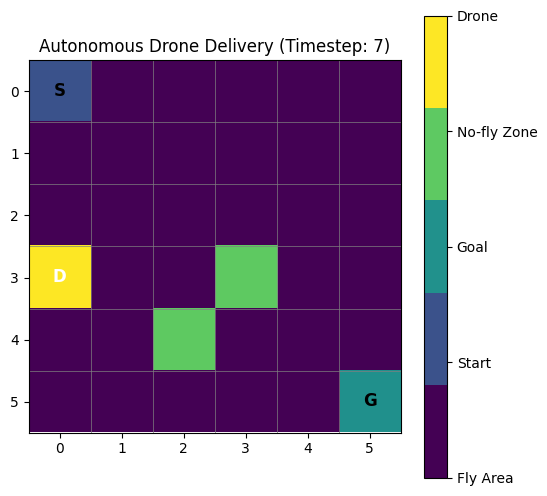

State: (3, 1), Reward: 4


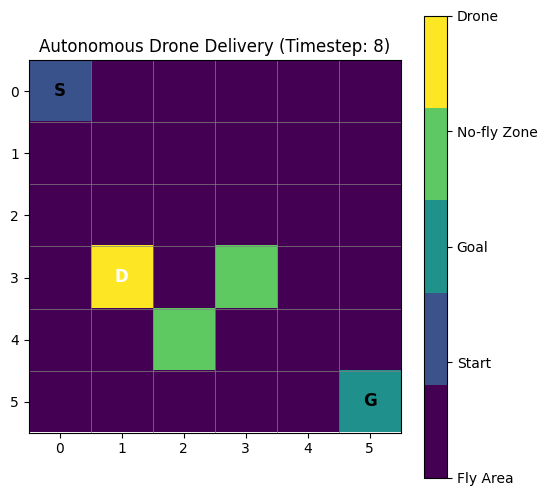

State: (3, 0), Reward: -1


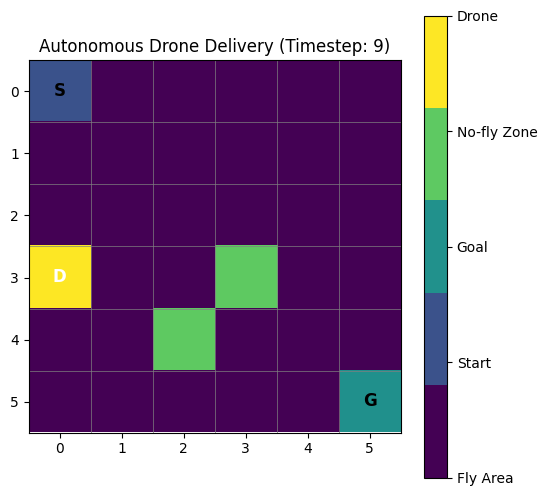

State: (3, 0), Reward: -1


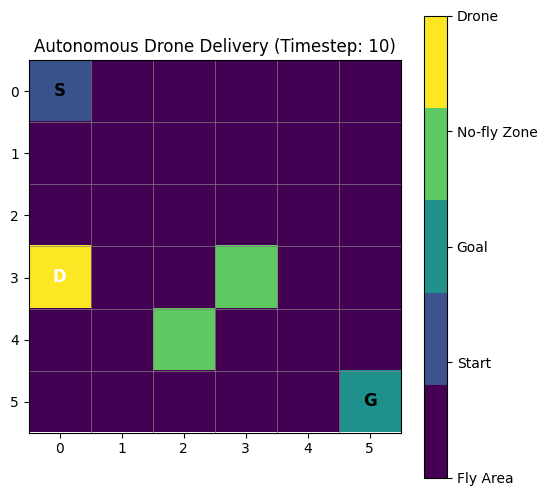

State: (3, 0), Reward: -1


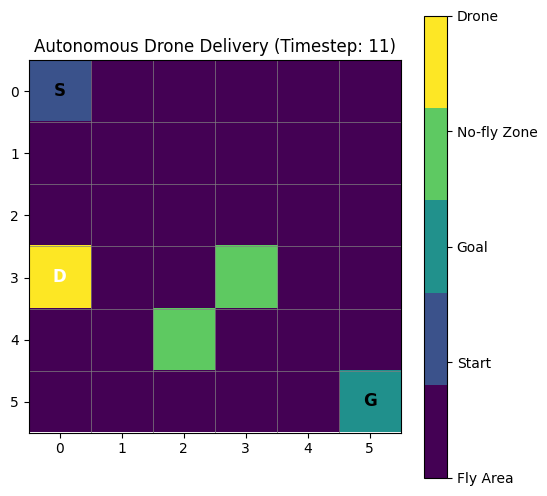

State: (3, 0), Reward: -1


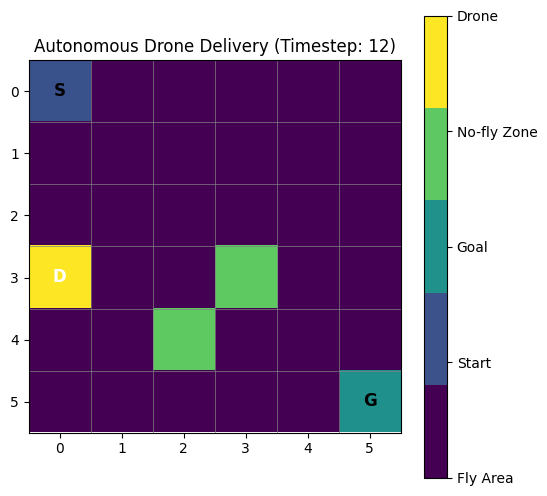

State: (1, 0), Reward: -1


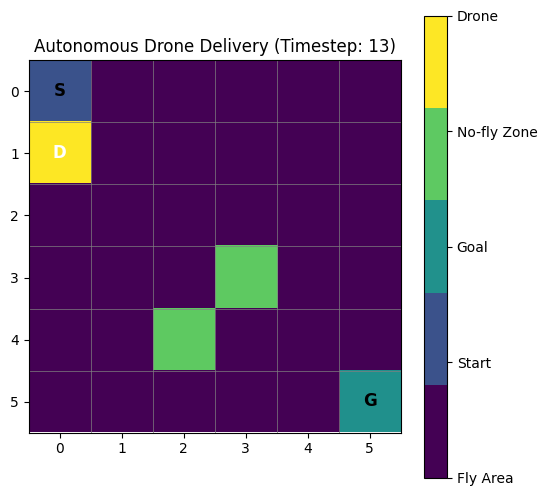

State: (1, 1), Reward: 4


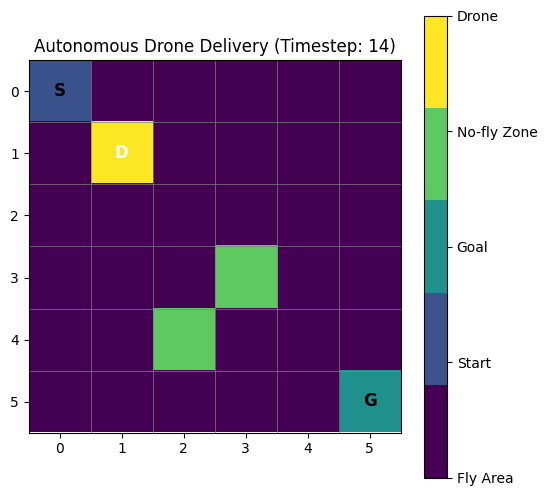

State: (1, 0), Reward: -1


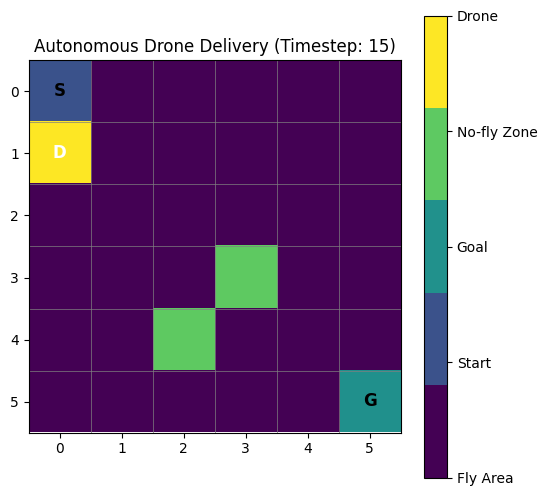

State: (1, 0), Reward: -1


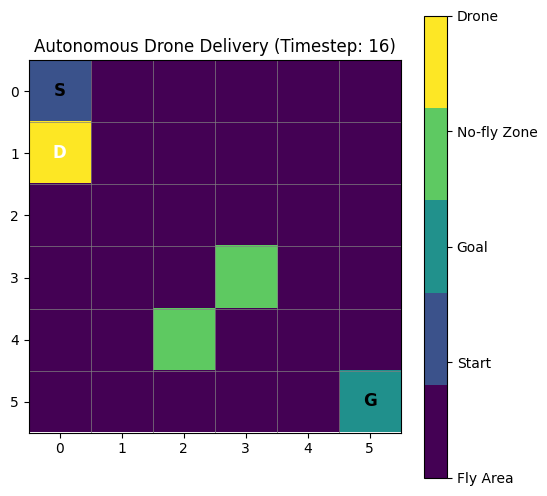

State: (0, 0), Reward: -1


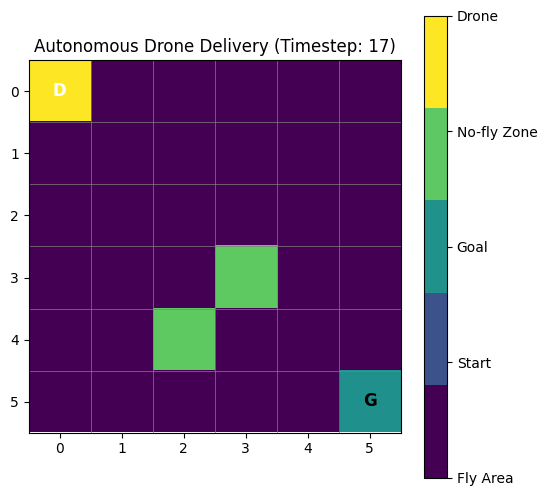

State: (0, 0), Reward: -1


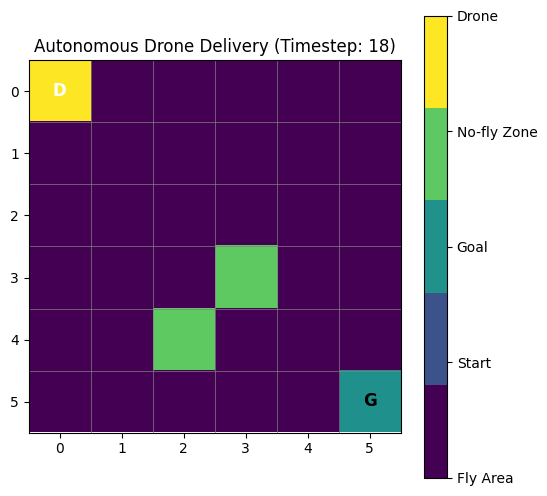

State: (0, 1), Reward: 4


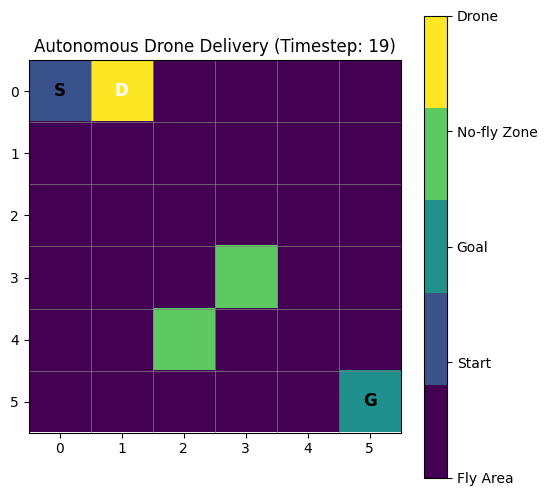

State: (0, 0), Reward: -1


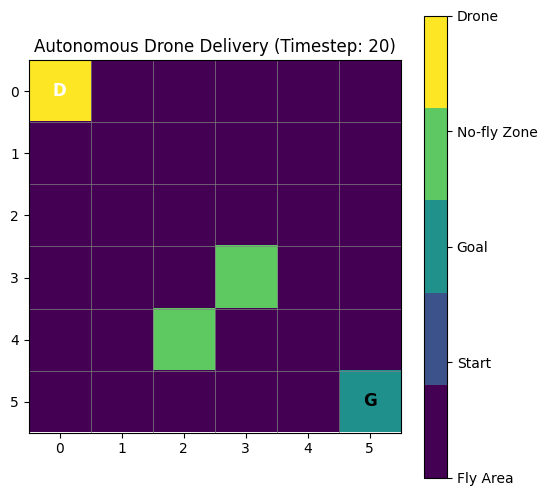

State: (0, 0), Reward: -1


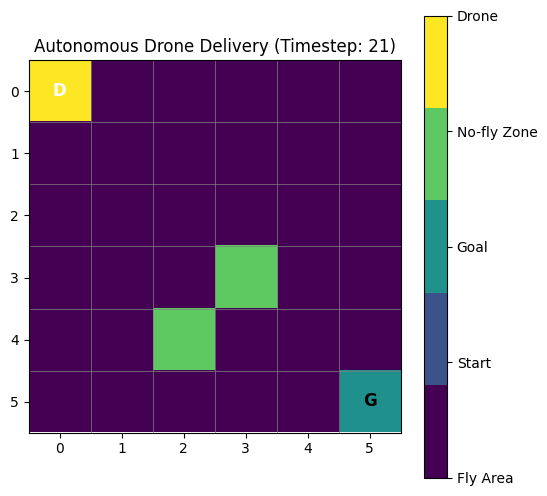

State: (0, 0), Reward: -1


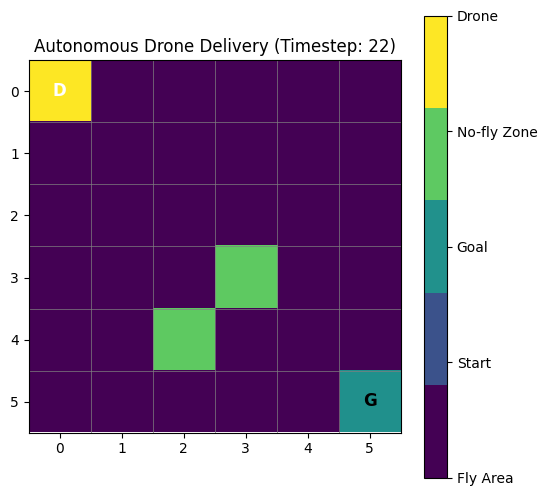

State: (1, 0), Reward: 4


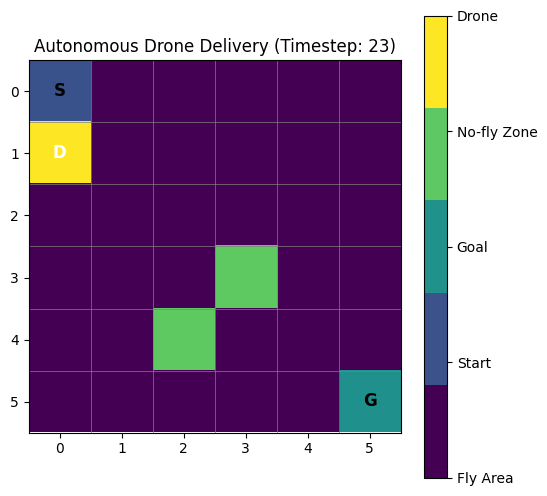

State: (1, 1), Reward: 4


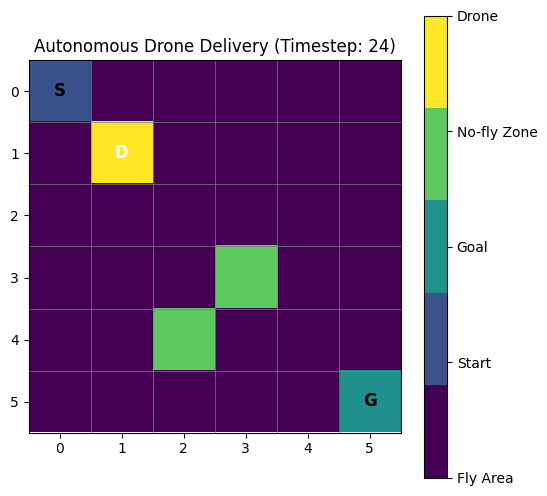

State: (2, 1), Reward: 4


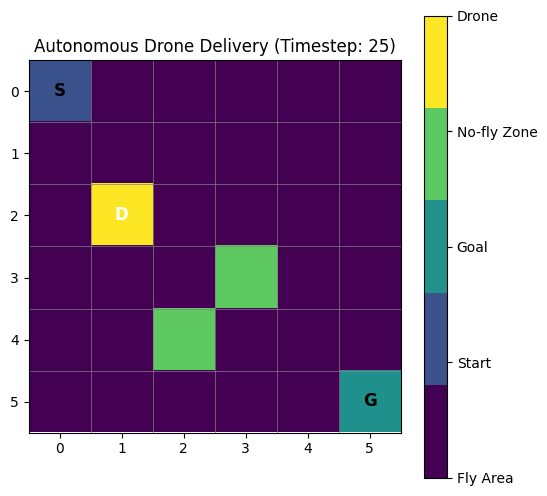

State: (2, 2), Reward: 4


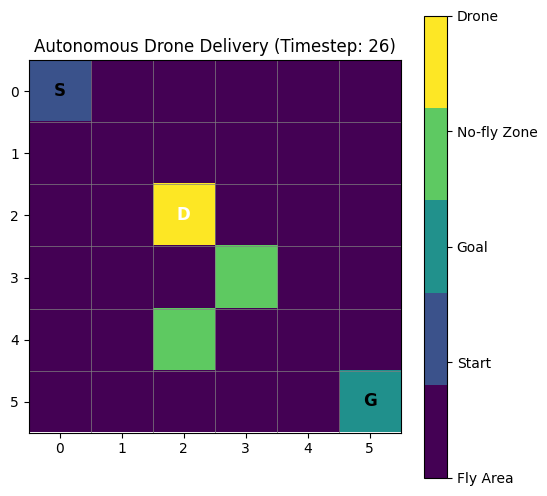

State: (3, 2), Reward: 4


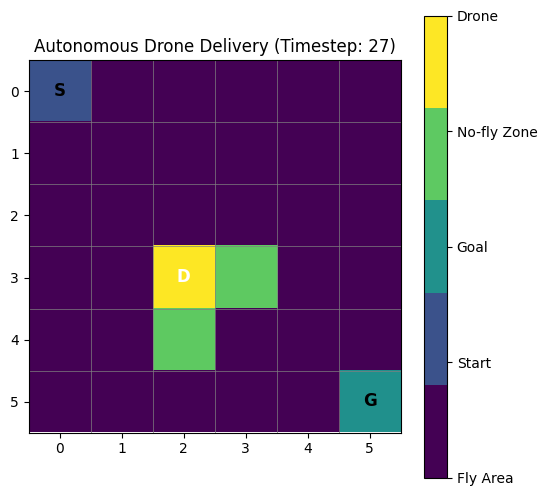

State: (3, 2), Reward: -1


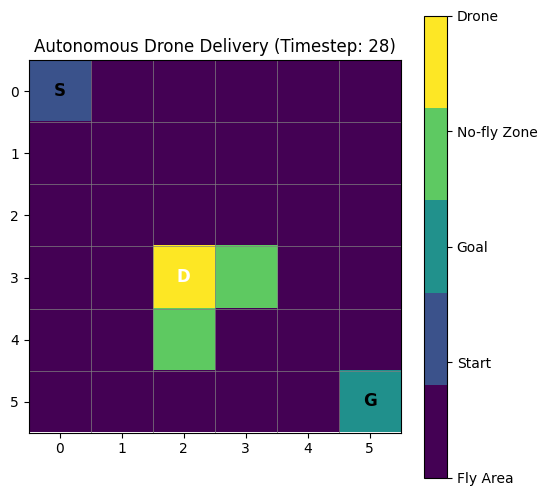

State: (3, 3), Reward: -15


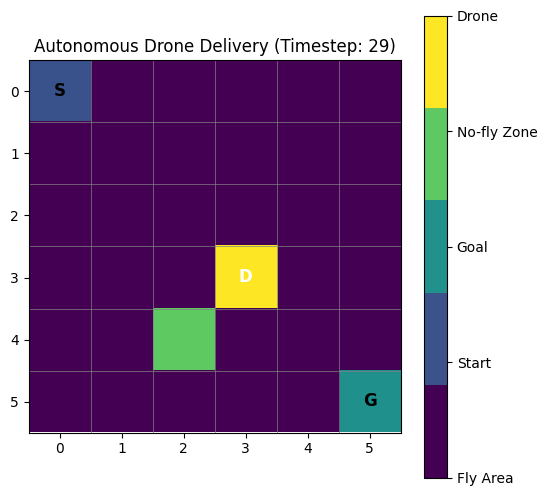

State: (3, 3), Reward: -20


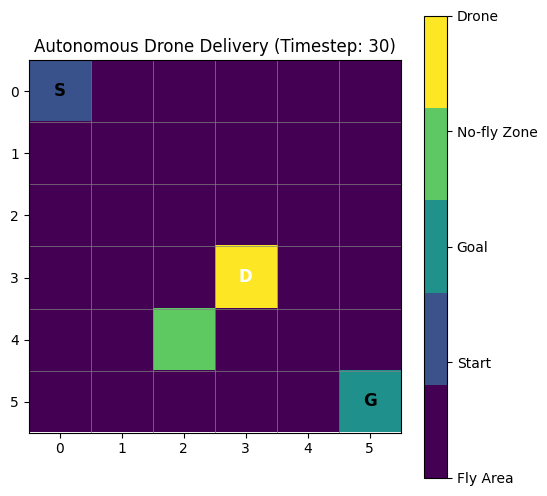

In [12]:
if __name__ == "__main__":
    # Deterministic Scenario
    env = DroneDeliveryEnv(deterministic=True)
    state = env.reset()
    print("Deterministic Environment:")
    for _ in range(30):
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print(f"State: {state}, Reward: {reward}")
        env.render()

    # Stochastic Scenario
    env_stochastic = DroneDeliveryEnv(deterministic=False)
    state = env_stochastic.reset()
    print("\nStochastic Environment:")
    for _ in range(30):
        action = env_stochastic.action_space.sample()
        state, reward, done, _ = env_stochastic.step(action)
        print(f"State: {state}, Reward: {reward}")
        env_stochastic.render()


### Bonus Task

In [13]:
class MultiDeliveryDroneEnv(gym.Env):
    def __init__(self, max_deliveries=3, deterministic=True):
        super(MultiDeliveryDroneEnv, self).__init__()

        self.grid_size = 6
        self.deterministic = deterministic
        self.start_position = (0, 0)  # Warehouse location
        self.goal_position = (5, 5)  # First delivery location
        self.no_fly_zones = [(3, 3), (4, 2)]  # Static obstacles

        # Action space: [Up, Down, Left, Right, Pickup, Drop-off]
        self.action_space = spaces.Discrete(6)

        # Observation space: drone position and delivery count
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size),
            spaces.Discrete(max_deliveries + 1)
        ))

        self.drone_position = None
        self.has_package = False
        self.time_step = 0
        self.max_deliveries = max_deliveries
        self.delivery_count = 0

        # Rewards
        self.rewards = {
            "step": -1,
            "no_fly_zone": -20,
            "delivery": 20
        }

    def reset(self):
        self.drone_position = self.start_position
        self.has_package = False
        self.time_step = 0
        self.delivery_count = 0
        self.goal_position = self._generate_new_goal()
        return (self.drone_position[0], self.drone_position[1], self.delivery_count)

    def step(self, action):
        x, y = self.drone_position

        if action == 0:  # Up
            new_x, new_y = x - 1, y
        elif action == 1:  # Down
            new_x, new_y = x + 1, y
        elif action == 2:  # Left
            new_x, new_y = x, y - 1
        elif action == 3:  # Right
            new_x, new_y = x, y + 1
        elif action == 4:  # Pickup
            if (x, y) == self.start_position:
                self.has_package = True
            new_x, new_y = x, y
        elif action == 5:  # Drop-off
            if (x, y) == self.goal_position and self.has_package:
                reward = self.rewards["delivery"]
                self.delivery_count += 1
                self.has_package = False

                if self.delivery_count >= self.max_deliveries:
                    return (new_x, new_y, self.delivery_count), reward, True, {}

                self.drone_position = self.start_position
                self.goal_position = self._generate_new_goal()
                return (self.drone_position[0], self.drone_position[1], self.delivery_count), reward, False, {}

            new_x, new_y = x, y

        if new_x < 0 or new_x >= self.grid_size or new_y < 0 or new_y >= self.grid_size:
            new_x, new_y = x, y

        # Stochastic movement
        if not self.deterministic:
            if np.random.uniform(0, 1) > 0.9:
                new_x, new_y = self._apply_random_drift(new_x, new_y)

        # Check for no-fly zones
        if (new_x, new_y) in self.no_fly_zones:
            reward = self.rewards["no_fly_zone"]
        else:
            reward = self.rewards["step"]

        self.drone_position = (new_x, new_y)
        self.time_step += 1
        done = False

        return (new_x, new_y, self.delivery_count), reward, done, {}

    def _generate_new_goal(self):
        while True:
            goal_x = np.random.randint(0, self.grid_size)
            goal_y = np.random.randint(0, self.grid_size)
            if (goal_x, goal_y) != self.start_position and (goal_x, goal_y) not in self.no_fly_zones:
                return (goal_x, goal_y)

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))

        for x, y in self.no_fly_zones:
            grid[x, y] = 3

        start_x, start_y = self.start_position
        goal_x, goal_y = self.goal_position
        drone_x, drone_y = self.drone_position

        grid[start_x, start_y] = 1
        grid[goal_x, goal_y] = 2
        grid[drone_x, drone_y] = 4

        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = plt.get_cmap("viridis", 5)
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=4)

        cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
        cbar.ax.set_yticklabels(['Empty', 'Start', 'Goal', 'No-fly Zone', 'Drone'])

        for (i, j), label in np.ndenumerate(grid):
            if label == 1:
                ax.text(j, i, 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 2:
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 4:
                ax.text(j, i, 'D', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

        plt.title(f"Deliveries Completed: {self.delivery_count}/{self.max_deliveries}, Time-step: {self.time_step}")
        plt.show()

    def _apply_random_drift(self, x, y):
        possible_moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        drift_x, drift_y = possible_moves[np.random.randint(0, 4)]
        new_x, new_y = x + drift_x, y + drift_y

        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            return new_x, new_y
        return x, y


Multiple Deliveries Environment:
State: (0, 0, 0), Reward: -1


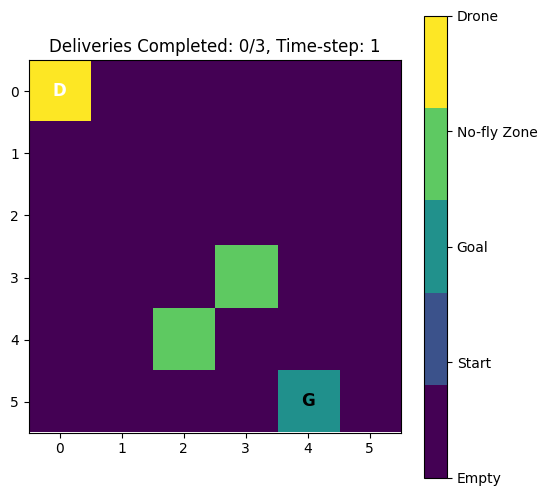

State: (0, 0, 0), Reward: -1


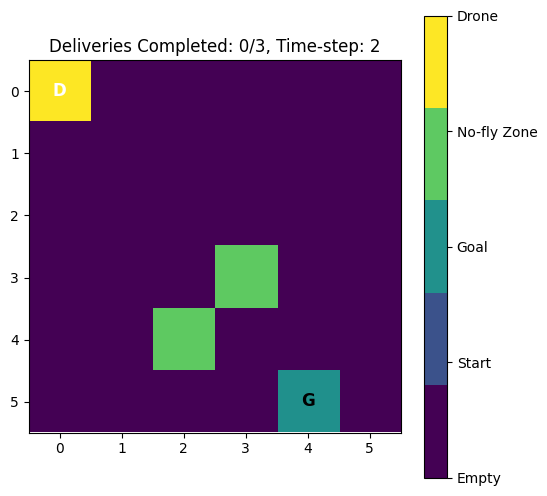

State: (0, 0, 0), Reward: -1


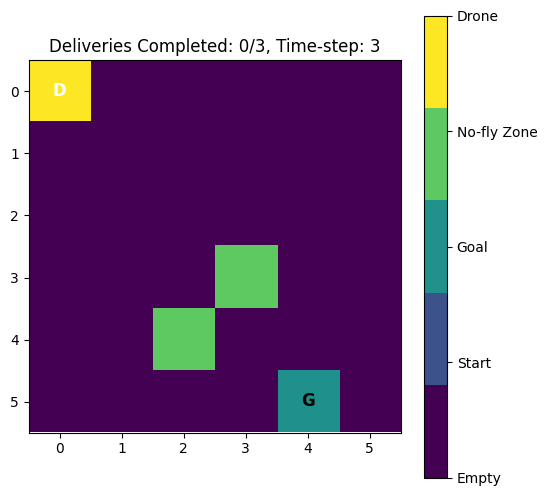

State: (0, 0, 0), Reward: -1


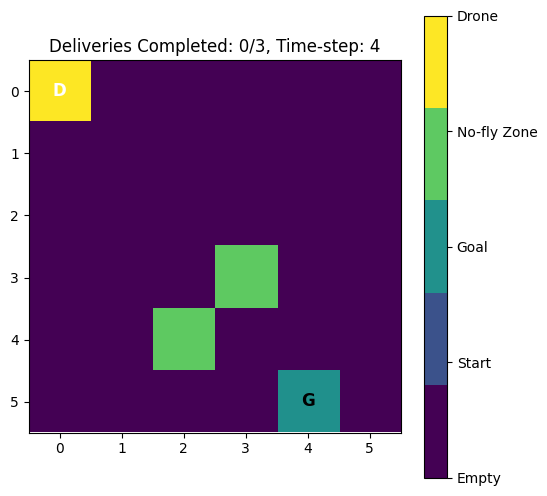

State: (0, 0, 0), Reward: -1


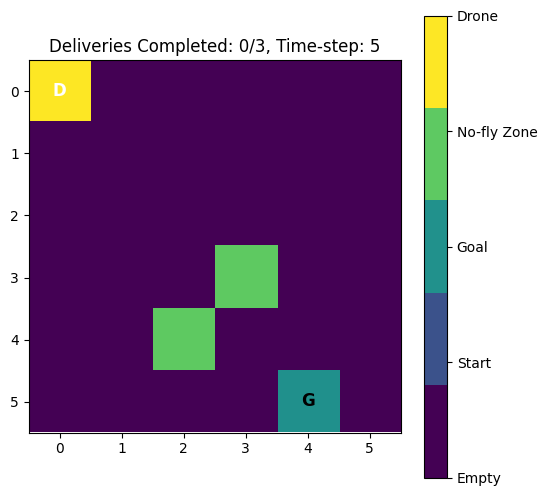

State: (0, 0, 0), Reward: -1


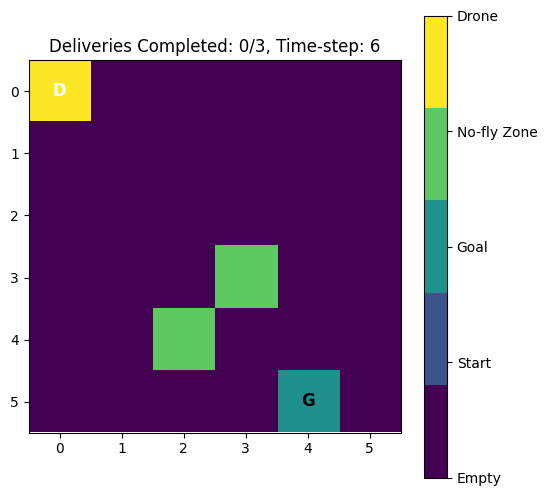

State: (0, 0, 0), Reward: -1


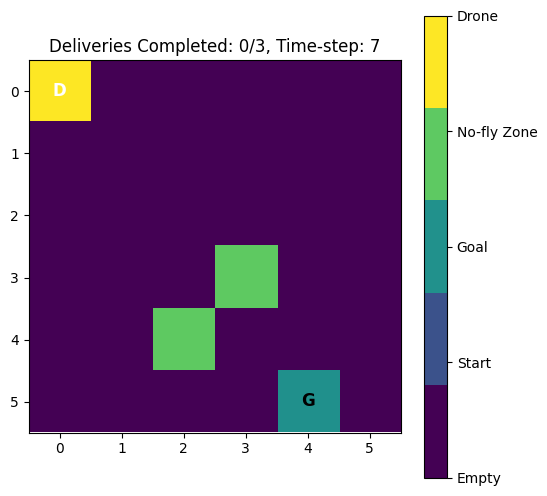

State: (0, 0, 0), Reward: -1


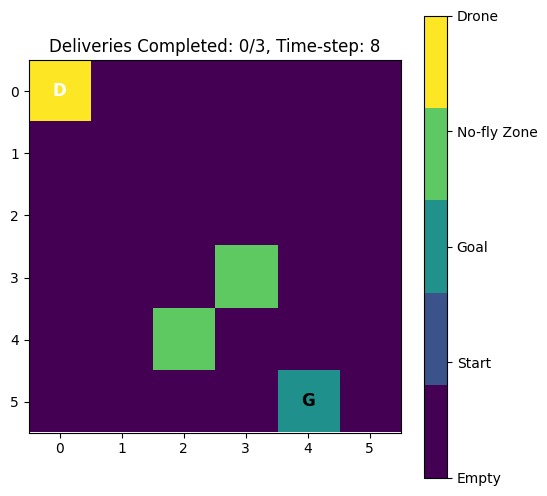

State: (0, 0, 0), Reward: -1


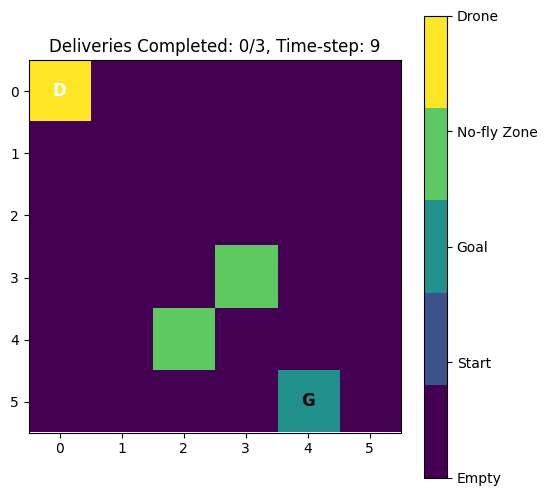

State: (0, 1, 0), Reward: -1


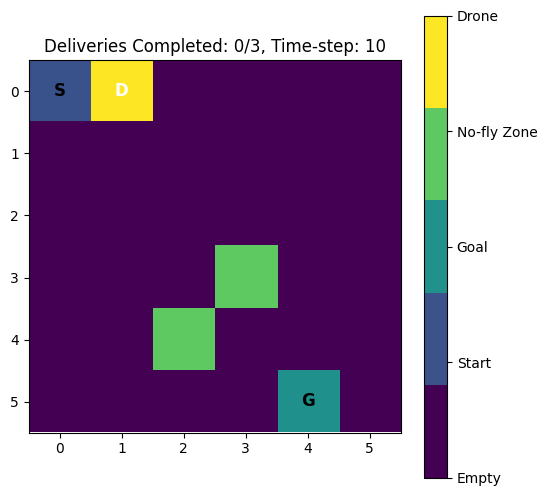

State: (0, 2, 0), Reward: -1


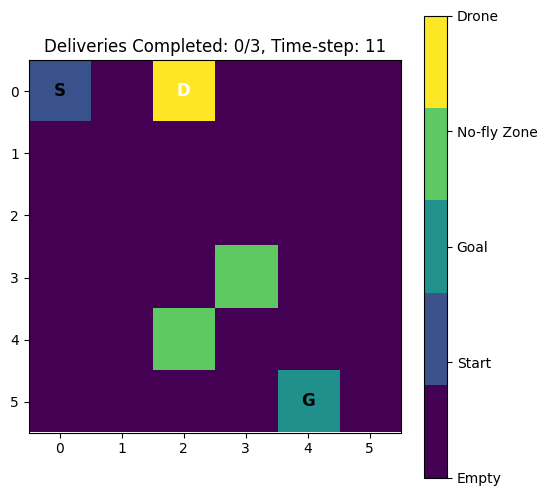

State: (1, 2, 0), Reward: -1


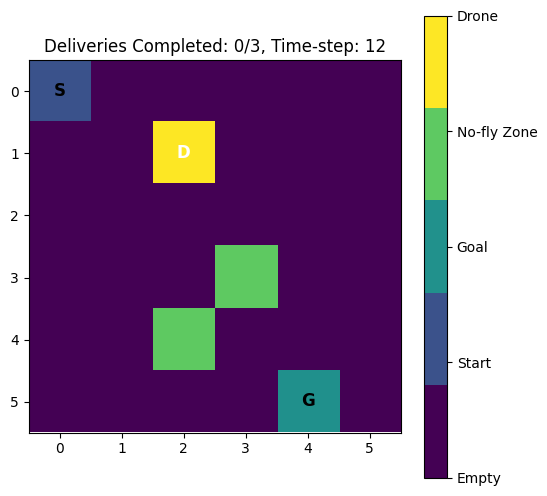

State: (1, 1, 0), Reward: -1


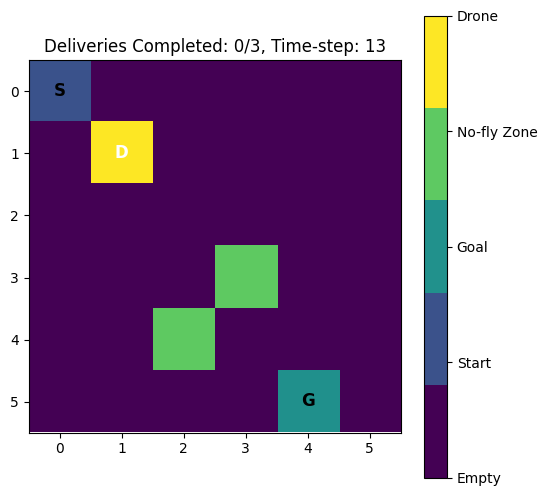

State: (1, 2, 0), Reward: -1


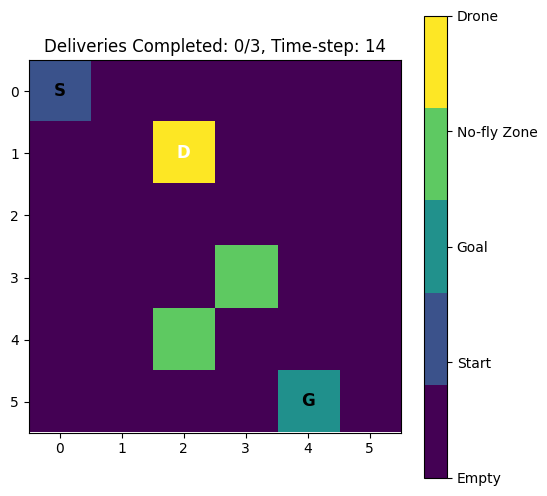

State: (0, 2, 0), Reward: -1


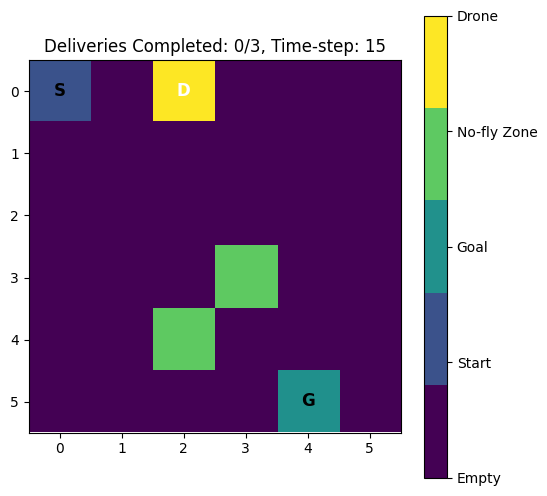

State: (1, 2, 0), Reward: -1


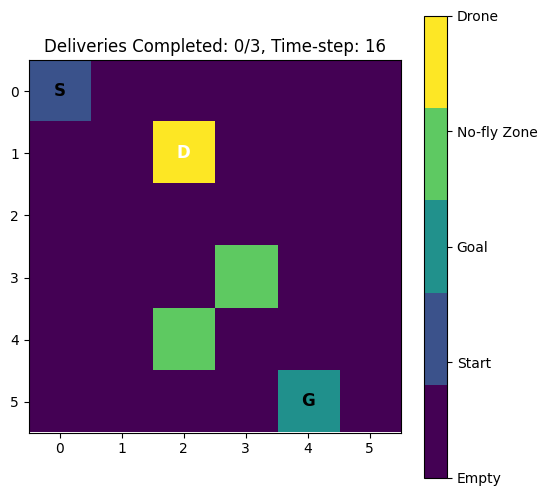

State: (1, 2, 0), Reward: -1


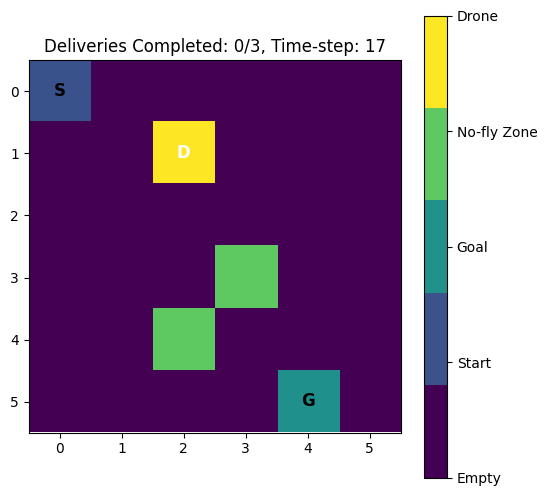

State: (1, 1, 0), Reward: -1


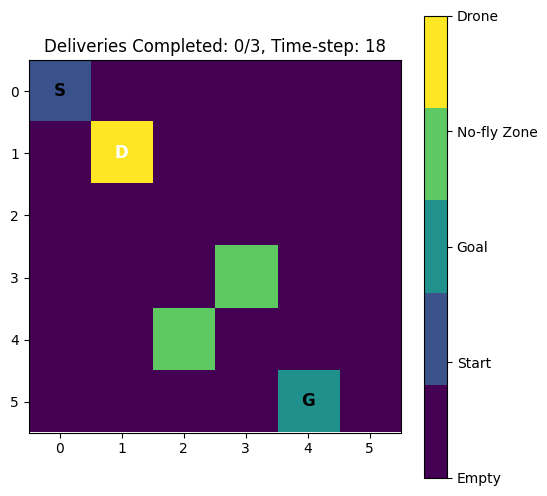

State: (1, 1, 0), Reward: -1


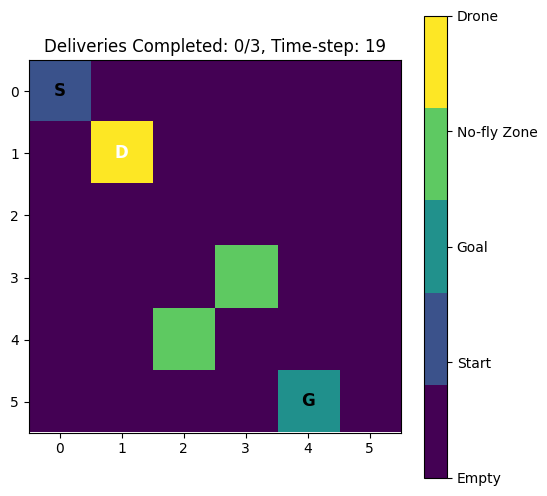

State: (1, 0, 0), Reward: -1


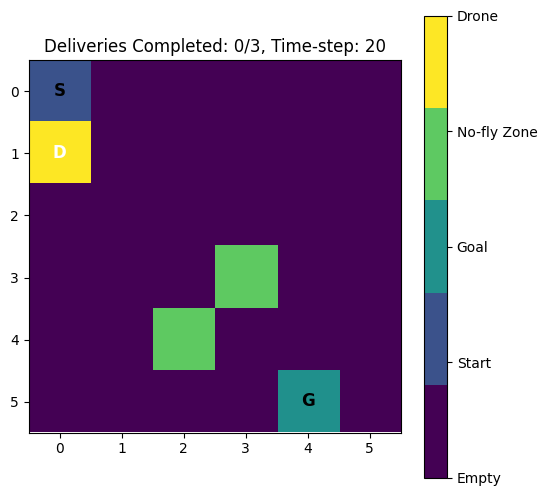

State: (1, 1, 0), Reward: -1


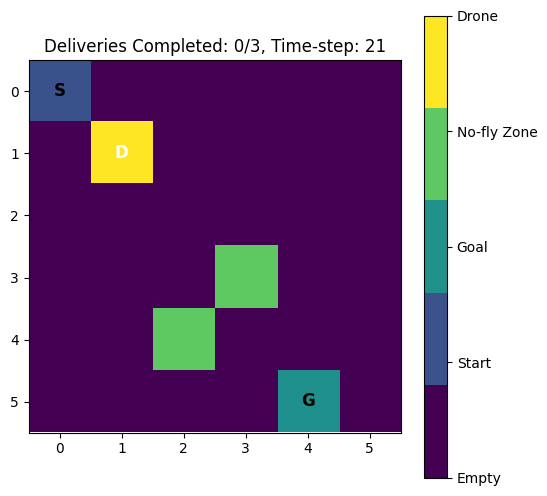

State: (1, 1, 0), Reward: -1


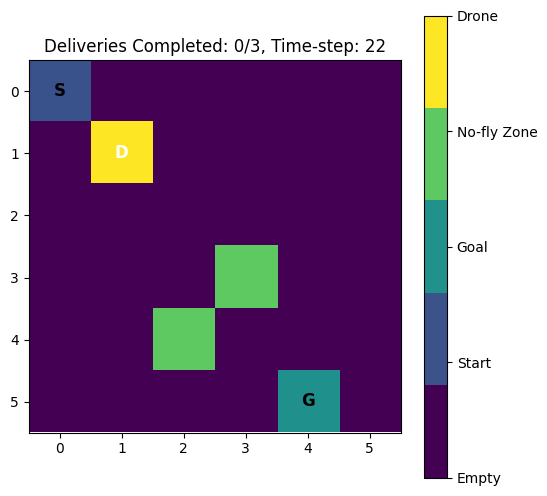

State: (1, 2, 0), Reward: -1


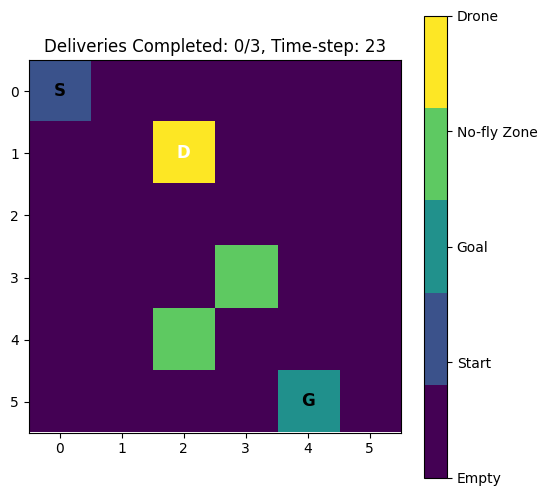

State: (1, 2, 0), Reward: -1


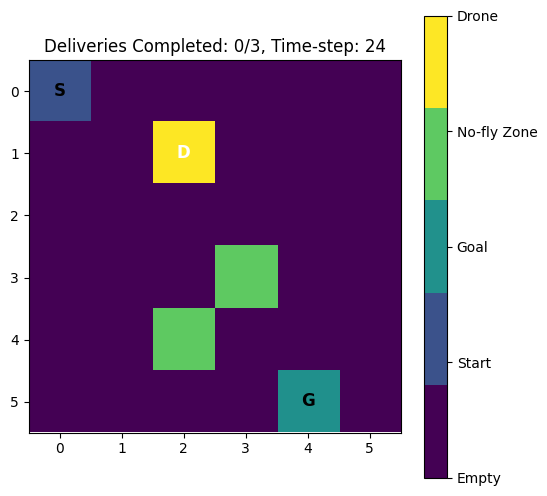

State: (1, 1, 0), Reward: -1


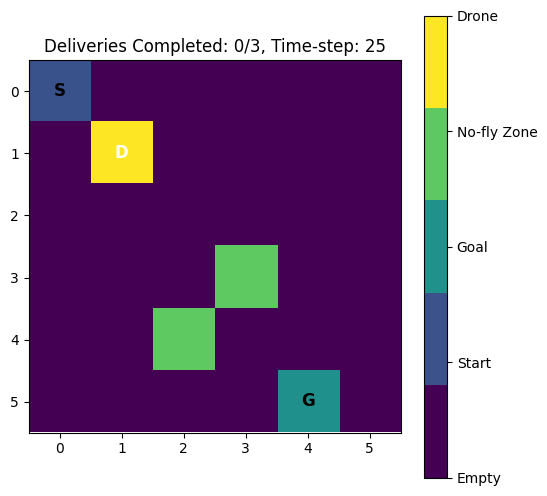

State: (1, 0, 0), Reward: -1


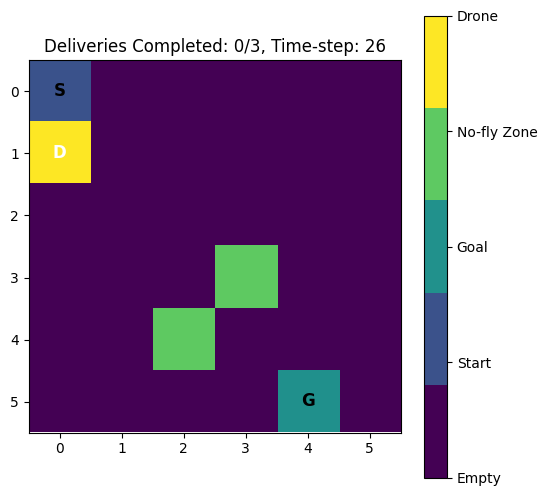

State: (0, 0, 0), Reward: -1


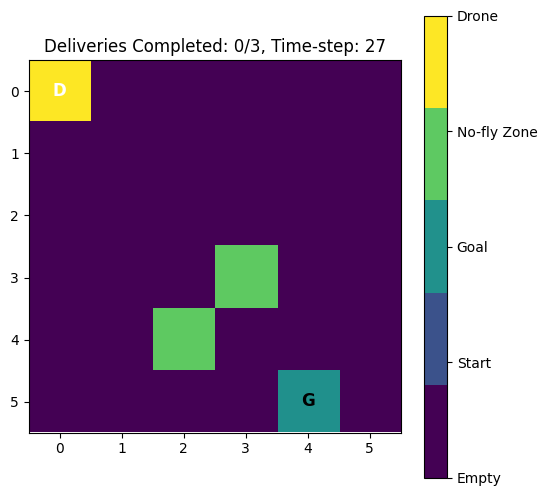

State: (1, 0, 0), Reward: -1


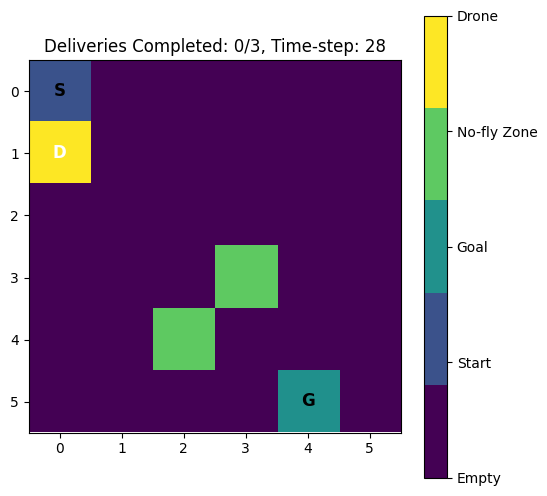

State: (1, 0, 0), Reward: -1


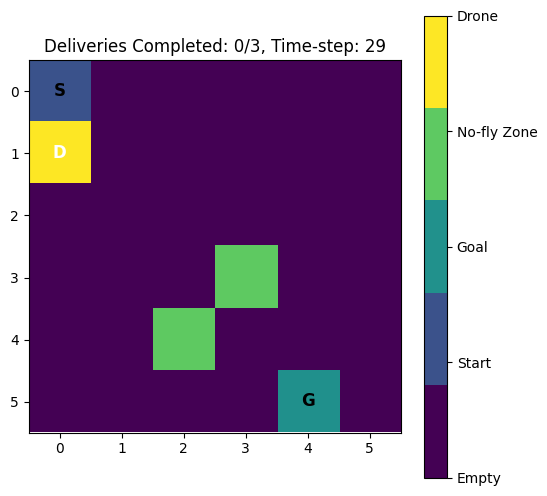

State: (1, 1, 0), Reward: -1


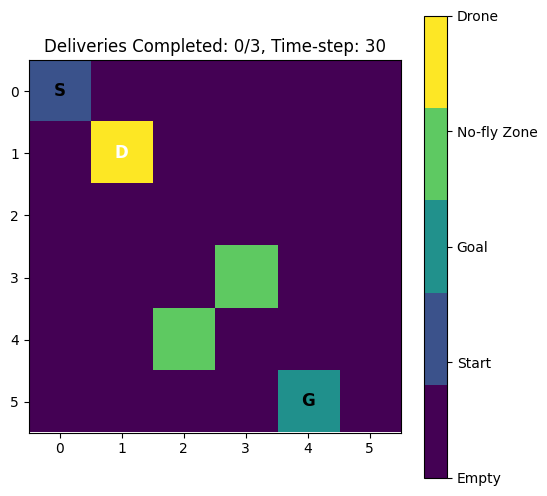

State: (1, 2, 0), Reward: -1


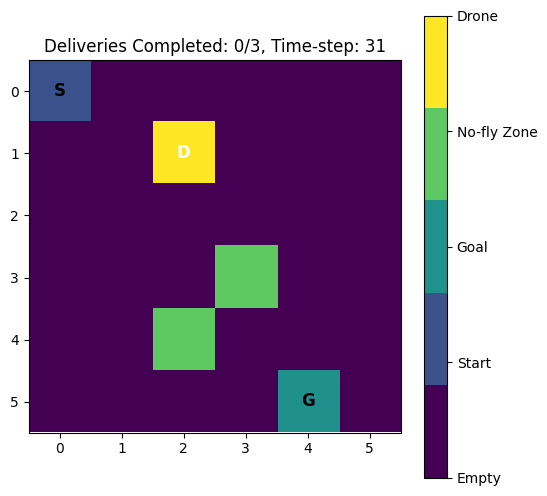

State: (0, 2, 0), Reward: -1


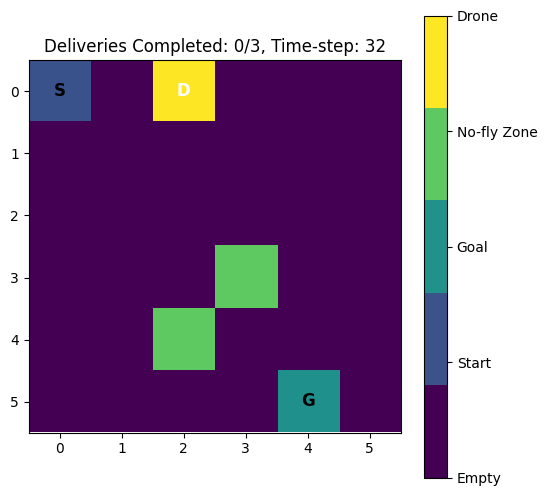

State: (0, 2, 0), Reward: -1


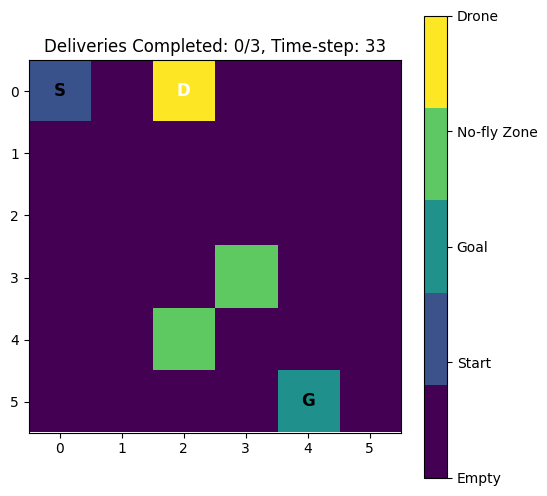

State: (0, 1, 0), Reward: -1


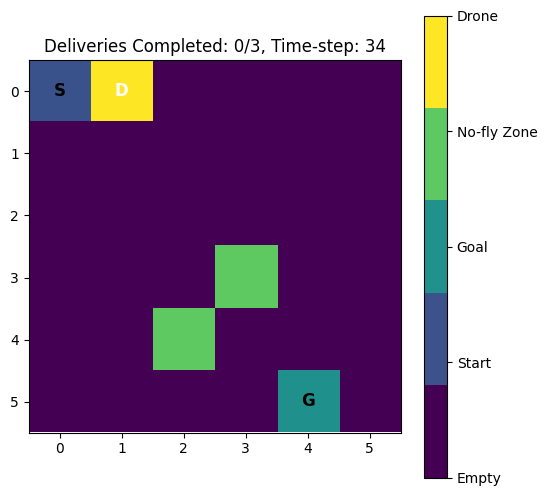

State: (0, 1, 0), Reward: -1


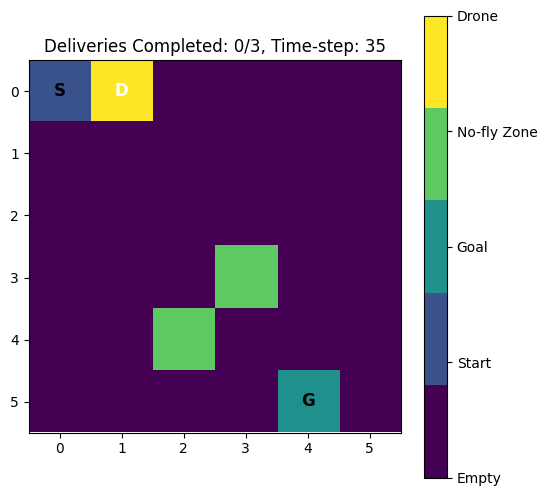

State: (0, 1, 0), Reward: -1


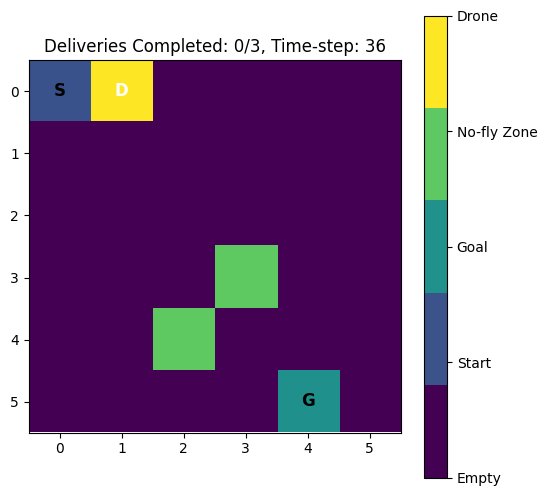

State: (0, 2, 0), Reward: -1


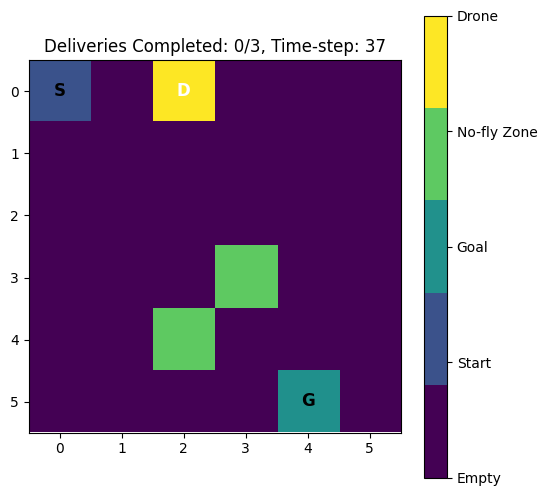

State: (0, 1, 0), Reward: -1


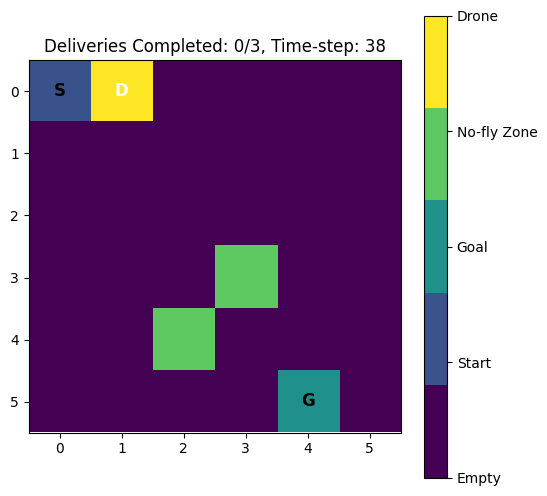

State: (0, 1, 0), Reward: -1


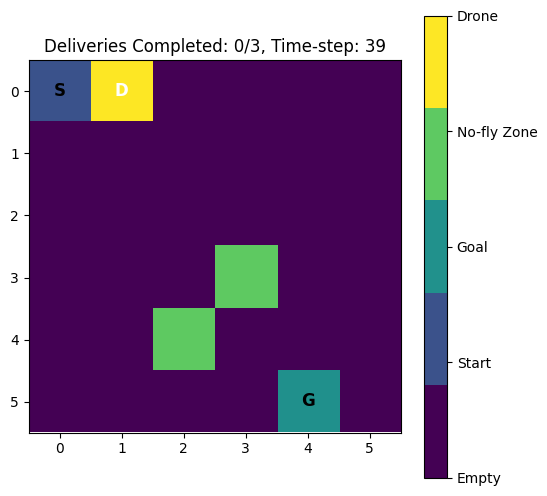

State: (0, 1, 0), Reward: -1


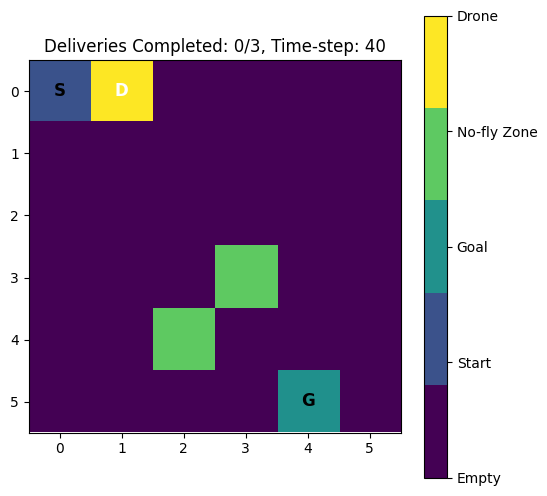

State: (0, 2, 0), Reward: -1


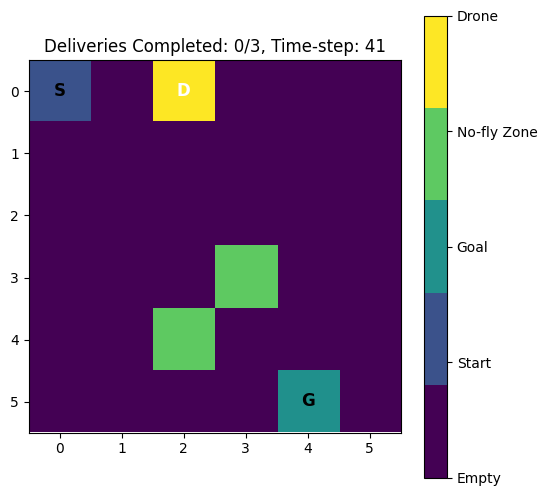

State: (0, 2, 0), Reward: -1


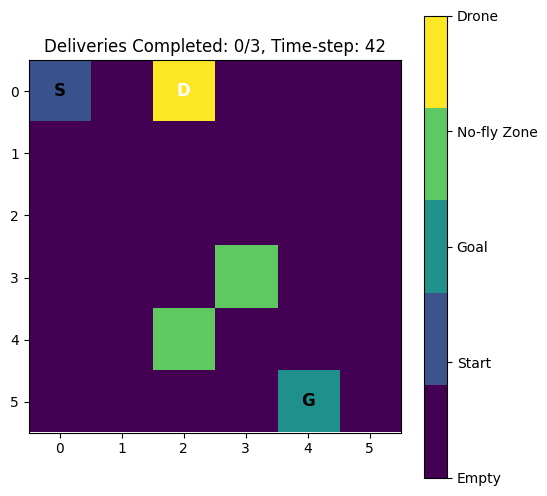

State: (0, 1, 0), Reward: -1


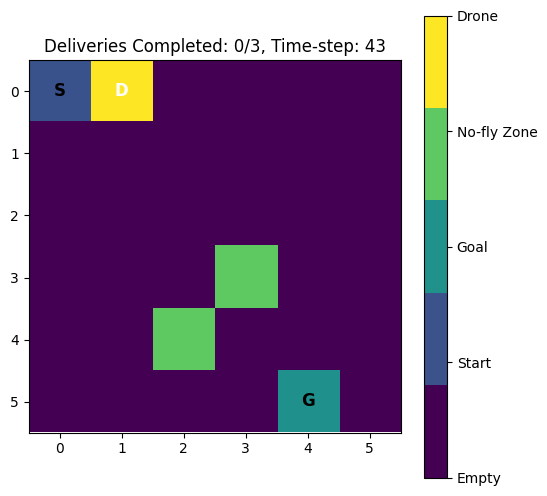

State: (0, 1, 0), Reward: -1


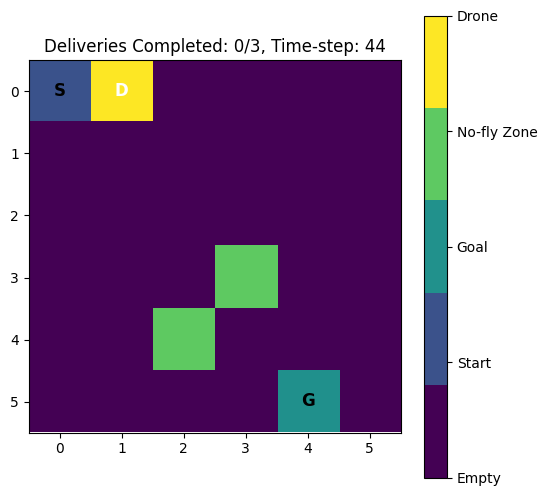

State: (0, 1, 0), Reward: -1


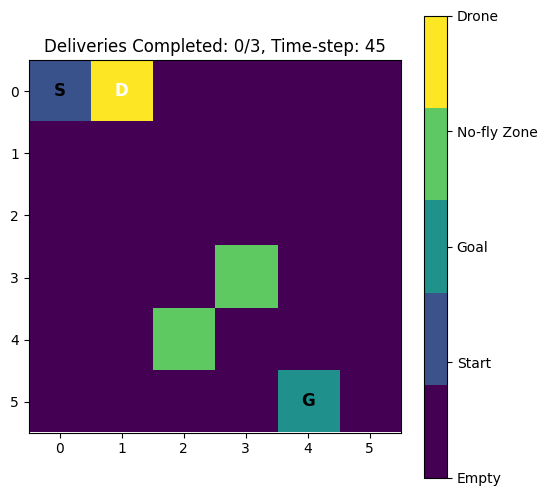

State: (1, 1, 0), Reward: -1


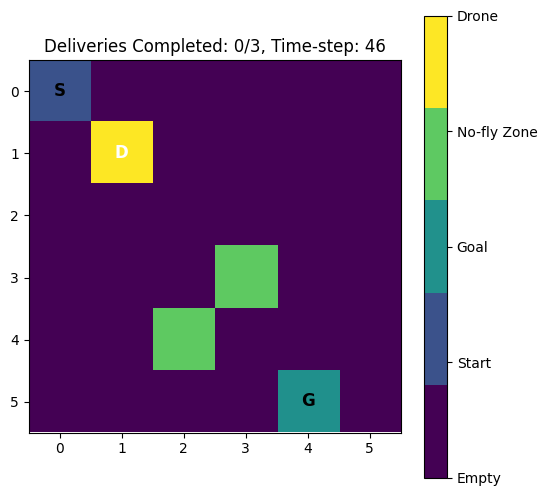

State: (2, 1, 0), Reward: -1


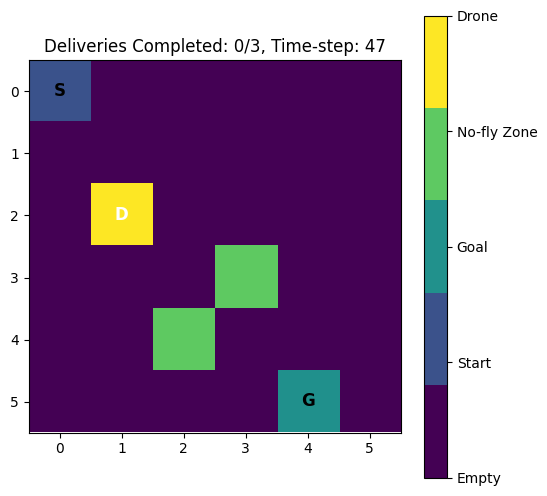

State: (2, 1, 0), Reward: -1


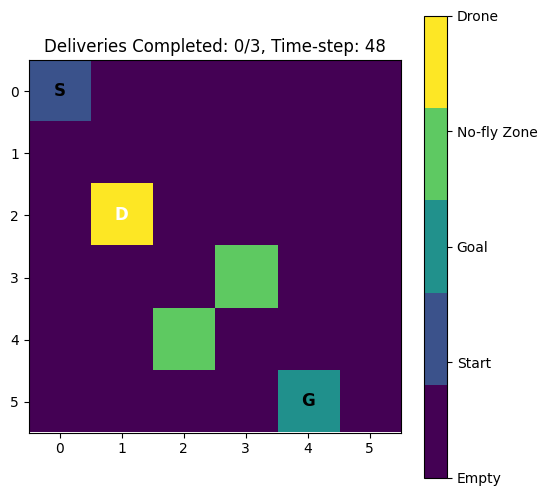

State: (3, 1, 0), Reward: -1


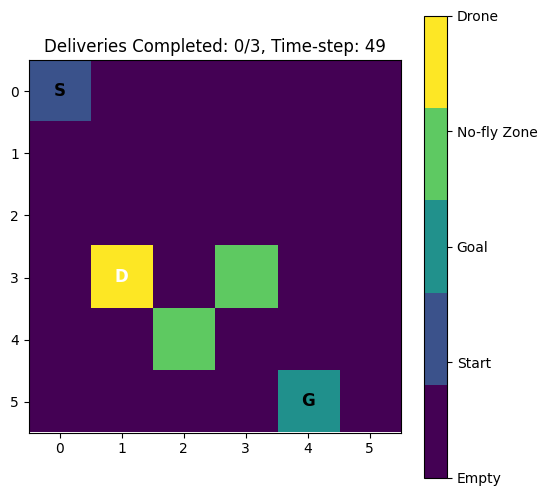

State: (3, 0, 0), Reward: -1


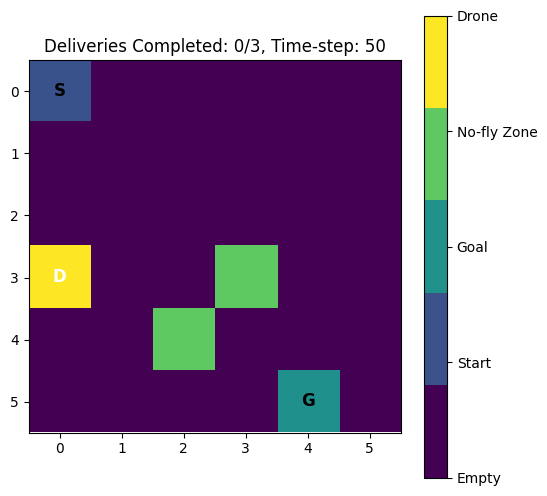

In [14]:
if __name__ == "__main__":
    env = MultiDeliveryDroneEnv(max_deliveries=3, deterministic=True)
    state = env.reset()
    print("Multiple Deliveries Environment:")

    for _ in range(50):
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print(f"State: {state}, Reward: {reward}")
        env.render()

## Part 2

In [32]:
# Agent QLearning

import pickle
import random

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum epsilon value

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.action_size)  # Random action (explore)
        return np.argmax(self.q_table[state])  # Best action (exploit)

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-values using Bellman Equation"""
        best_future_q = np.max(self.q_table[next_state])
        current_q = self.q_table[state, action]
        self.q_table[state, action] = current_q + self.alpha * (reward + self.gamma * best_future_q - current_q)

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_q_table(self, filename):
        """Save Q-table as a pickle file"""
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename):
        """Load Q-table from a pickle file"""
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


def train_q_learning(env, agent, num_episodes=1000):
    rewards_per_episode = []
    epsilon_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0

        done = False
        while not done:
            action = agent.choose_action(state_index)
            next_state, reward, done, _ = env.step(action)
            next_state_index = next_state[0] * env.grid_size + next_state[1]

            agent.update_q_table(state_index, action, reward, next_state_index)

            state_index = next_state_index
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon_values.append(agent.epsilon)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}: Reward = {total_reward}")
    return rewards_per_episode, epsilon_values


def evaluate_q_learning(env, agent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(agent.q_table[state_index])  # Greedy action
            state, reward, done, _ = env.step(action)
            state_index = state[0] * env.grid_size + state[1]
            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards


def plot_results(rewards, epsilon_values, evaluation_rewards):
    episodes = range(len(rewards))

    # Total Rewards per Episode
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward Per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodes, epsilon_values, label="Epsilon Decay", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Time")
    plt.legend()
    plt.show()

    # Evaluation Rewards
    plt.figure(figsize=(6, 5))
    plt.plot(range(len(evaluation_rewards)), evaluation_rewards, marker='o', label="Evaluation Rewards", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation of Greedy Policy")
    plt.legend()
    plt.show()



Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 36
Episode 100/1000: Reward = 61
Episode 150/1000: Reward = 71
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 75
Episode 300/1000: Reward = 81
Episode 350/1000: Reward = 76
Episode 400/1000:

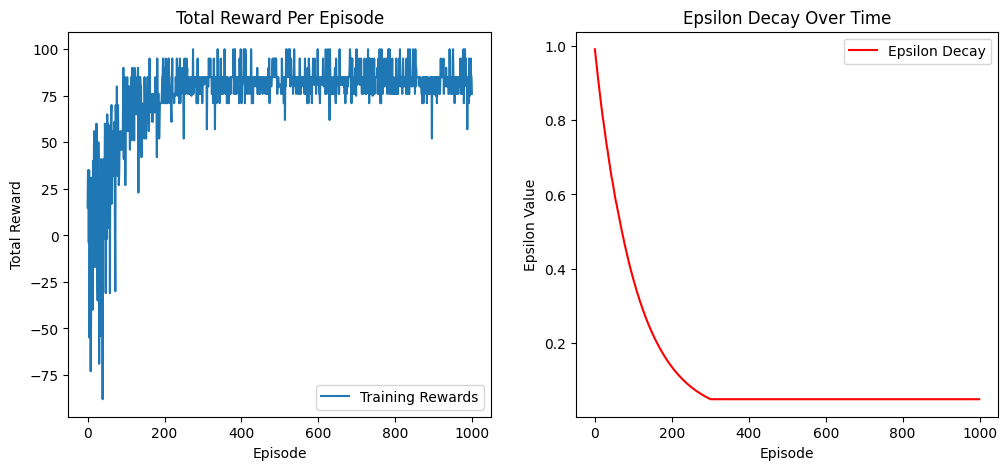

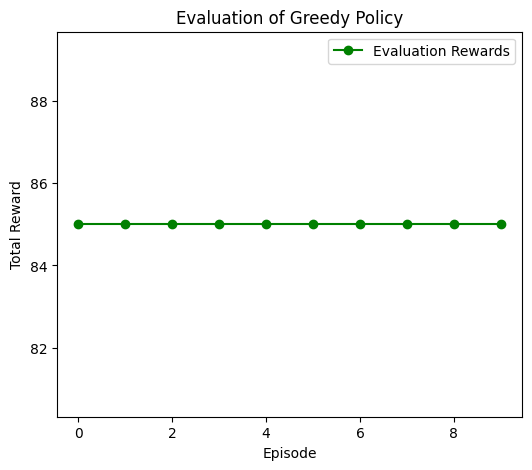

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 21
Episode 100/1000: Reward = 41
Episode 150/1000: Reward = 75
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 85
Episode 300/1000: Reward = 90
Episode 350/1000: Reward = 90
Episode 400/1000:

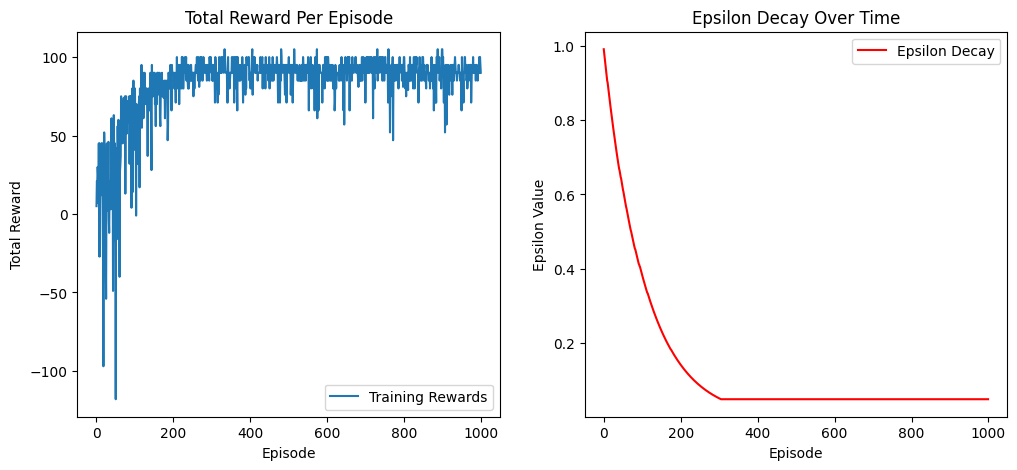

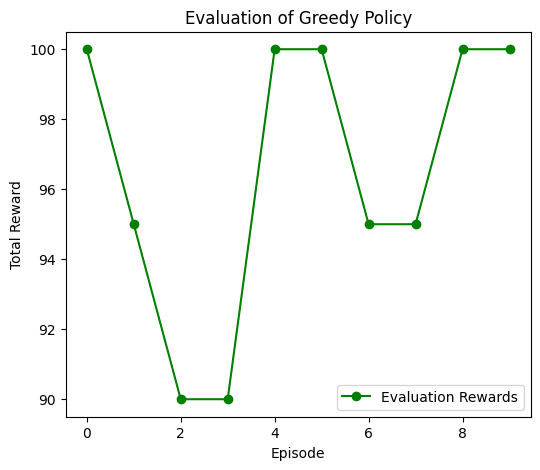

In [33]:
# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_deterministic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)



# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

###Hyper-Parameter Tuning


### Hyperparameter #1 - Changing Gamma values

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 100
Episode 100/1000: Reward = 95
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/1000

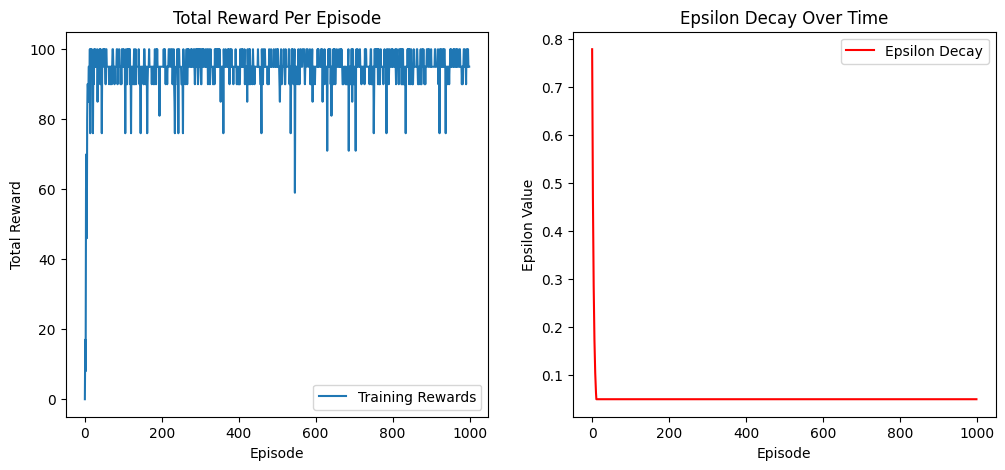

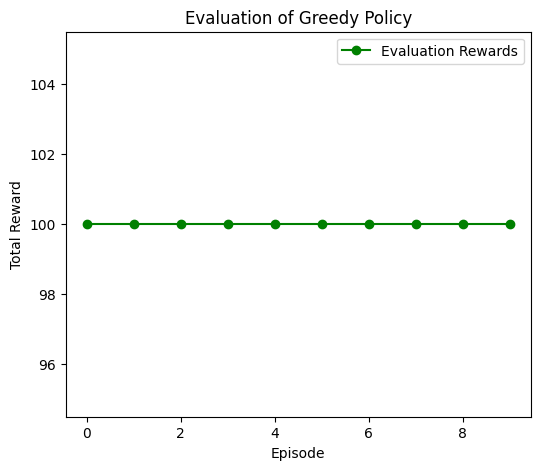

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 71
Episode 100/1000: Reward = 71
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 56
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 71
Episode 400/1000:

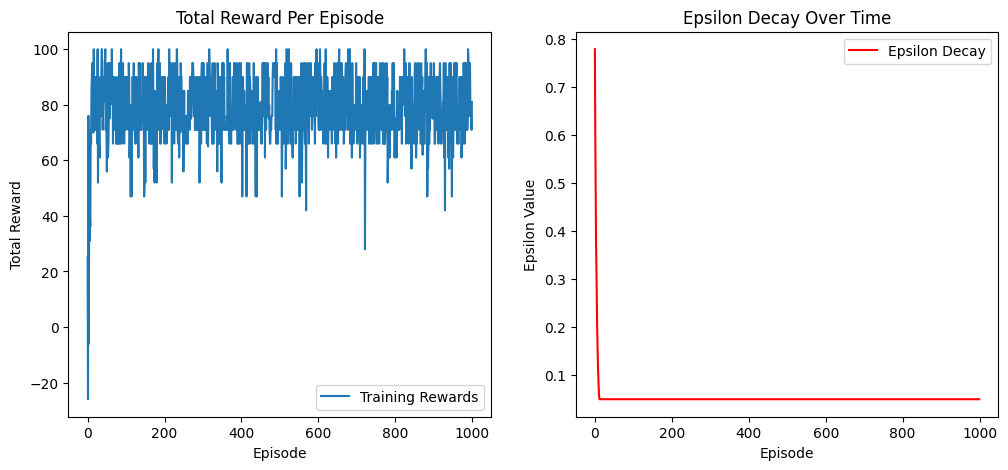

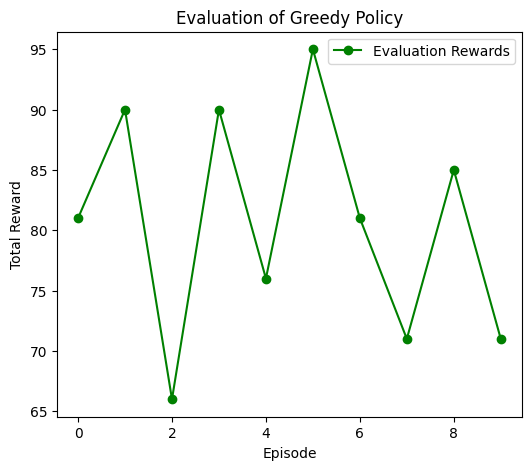

In [17]:
# gamma = 0.99, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 100
Episode 100/1000: Reward = 100
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 100
Episode 300/1000: Reward = 90
Episode 350/1000: Reward = 95
Episode 400/10

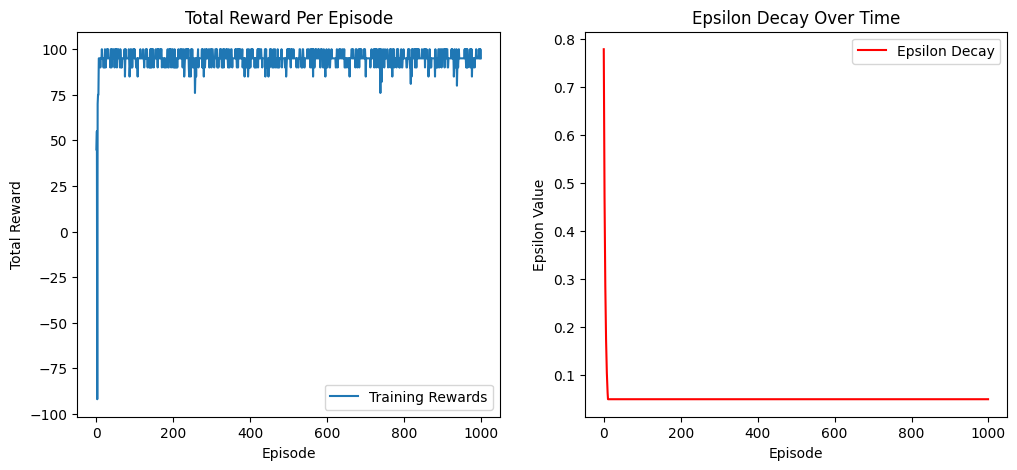

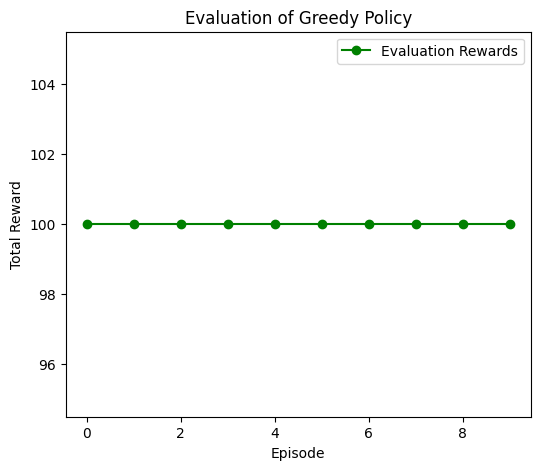

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 95
Episode 100/1000: Reward = 71
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 80
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 100
Episode 400/1000

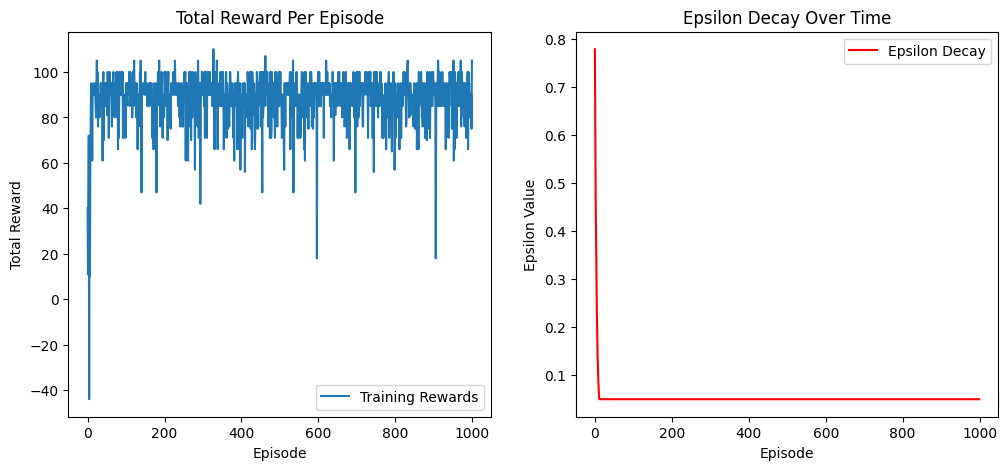

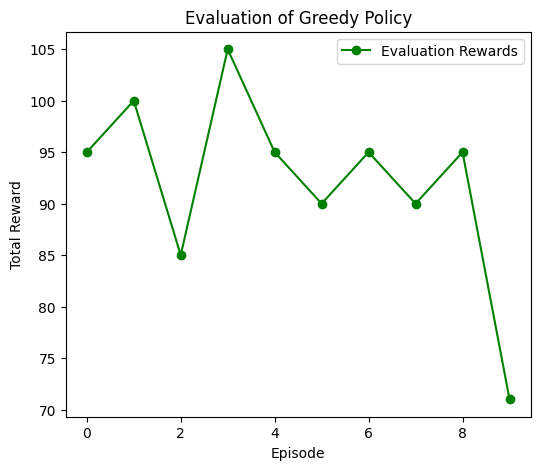

In [18]:
# gamma = 0.95, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 95
Episode 100/1000: Reward = 95
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/1000:

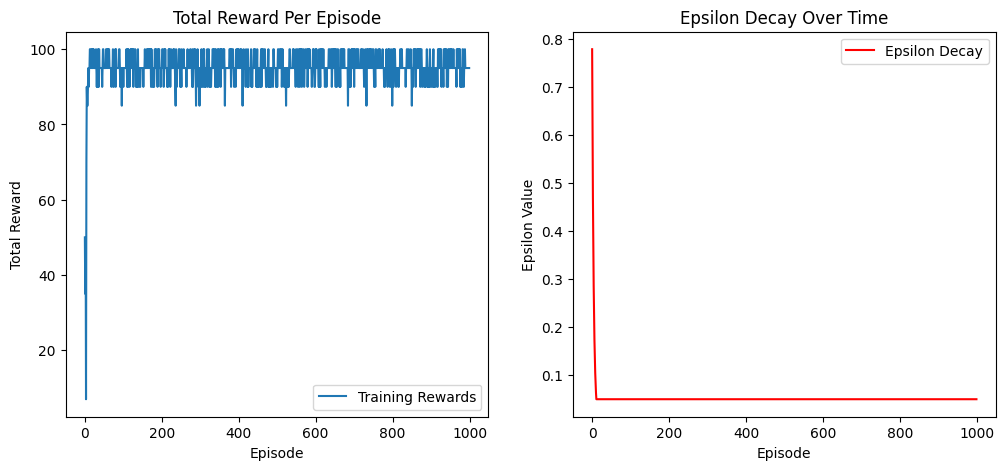

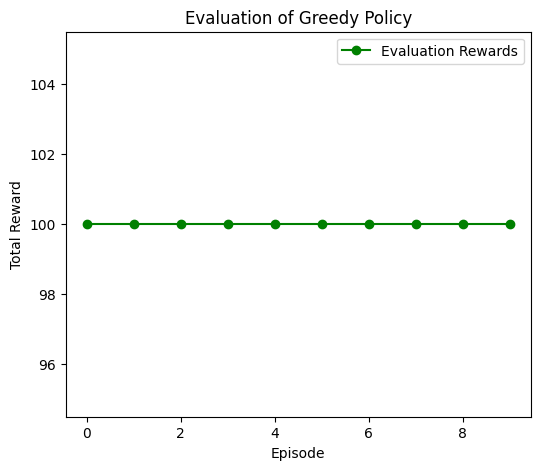

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 90
Episode 100/1000: Reward = 95
Episode 150/1000: Reward = 100
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 100
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 66
Episode 400/100

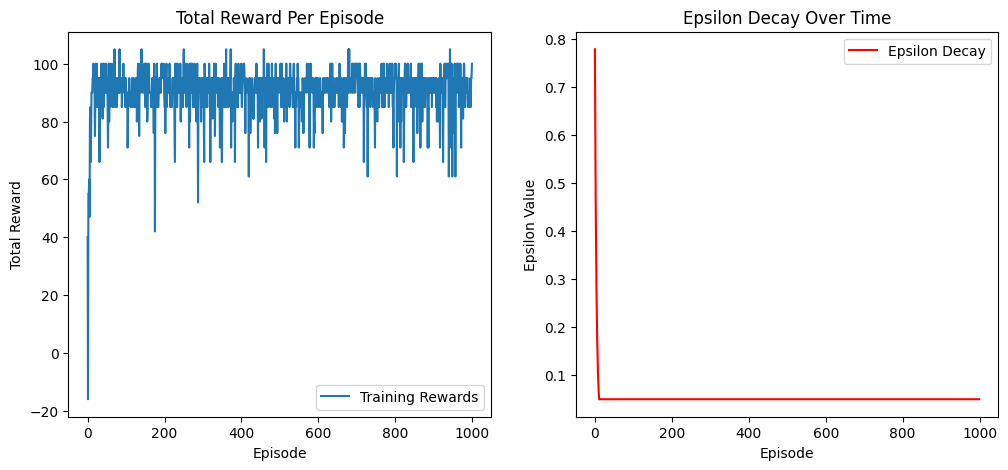

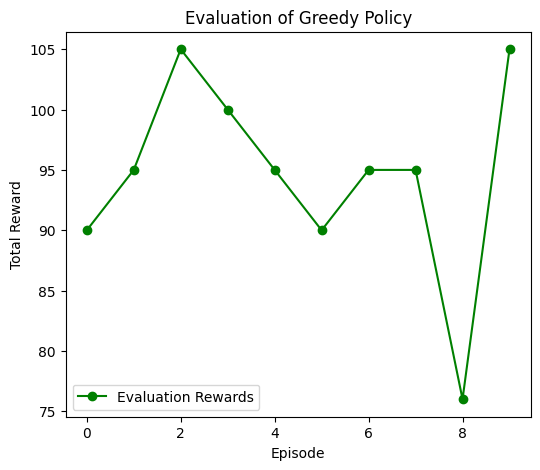

In [19]:
# gamma = 0.80, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.80,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.80,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

### Hyperparameter #2 - Changing Epsilon values

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 65
Episode 100/1000: Reward = 70
Episode 150/1000: Reward = 85
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 100
Episode 350/1000: Reward = 100
Episode 400/100

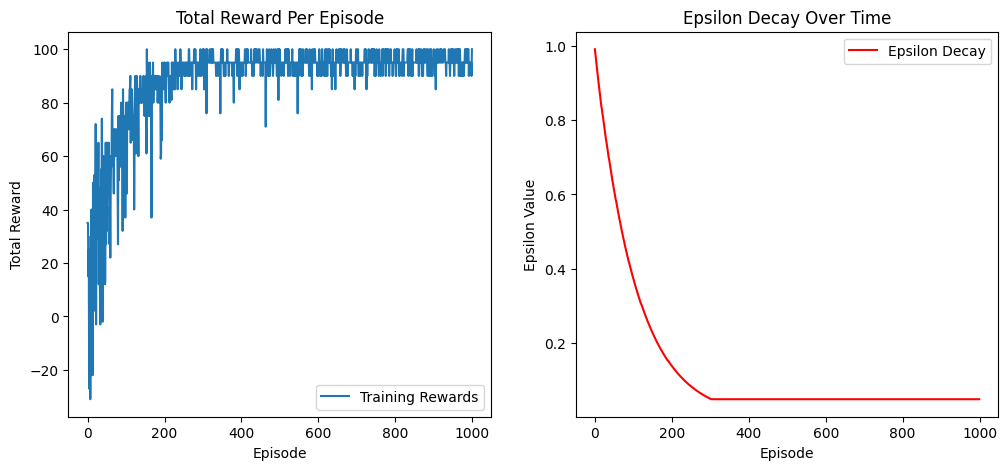

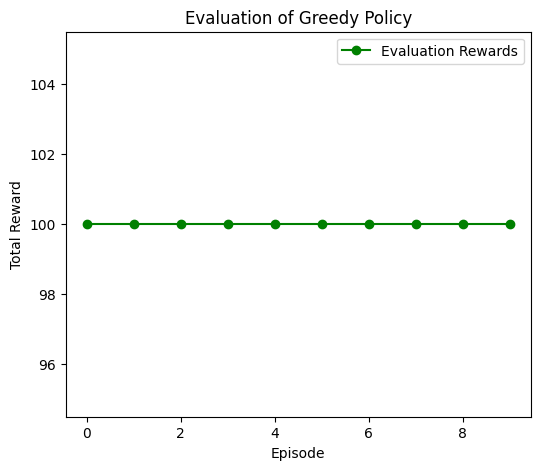

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 22
Episode 100/1000: Reward = 70
Episode 150/1000: Reward = 46
Episode 200/1000: Reward = 80
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 100
Episode 350/1000: Reward = 100
Episode 400/100

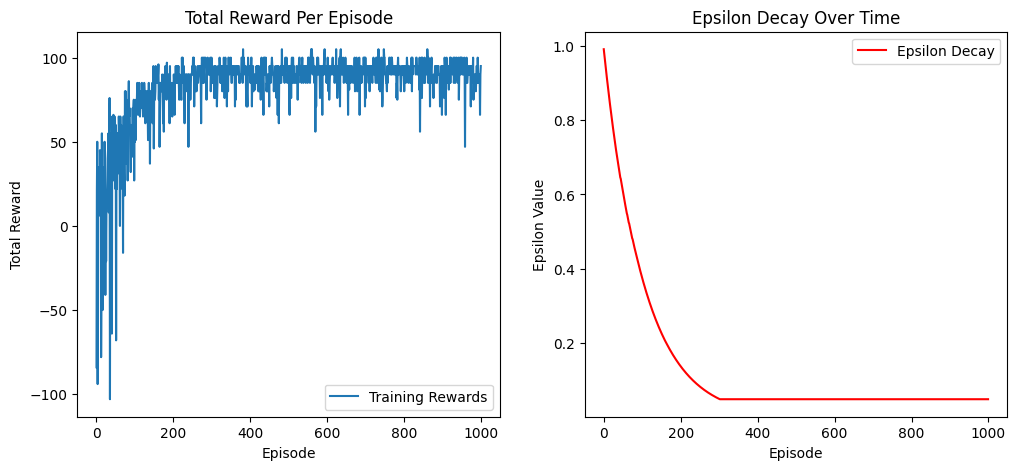

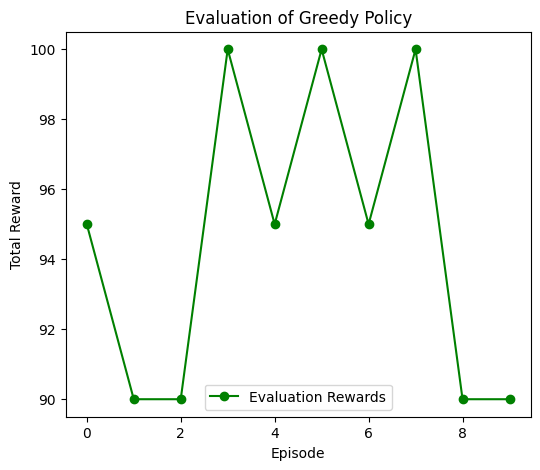

In [20]:
# gamma = 0.99, epsilon = 0.9998

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 80
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 100
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 100
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/100

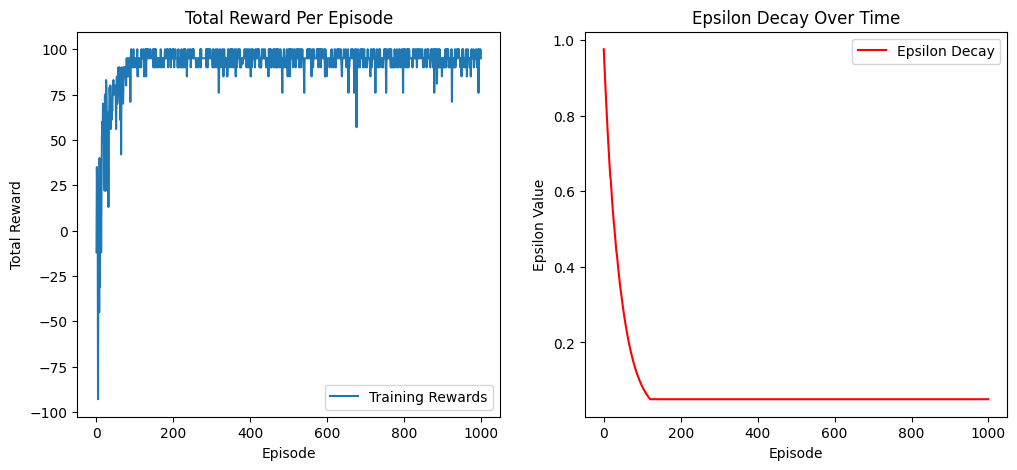

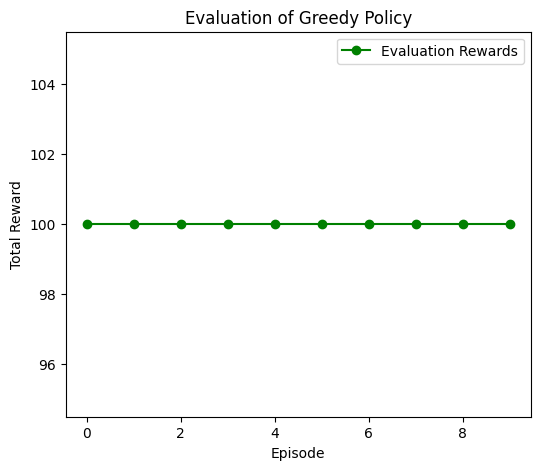

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 85
Episode 100/1000: Reward = 85
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 100
Episode 350/1000: Reward = 85
Episode 400/1000

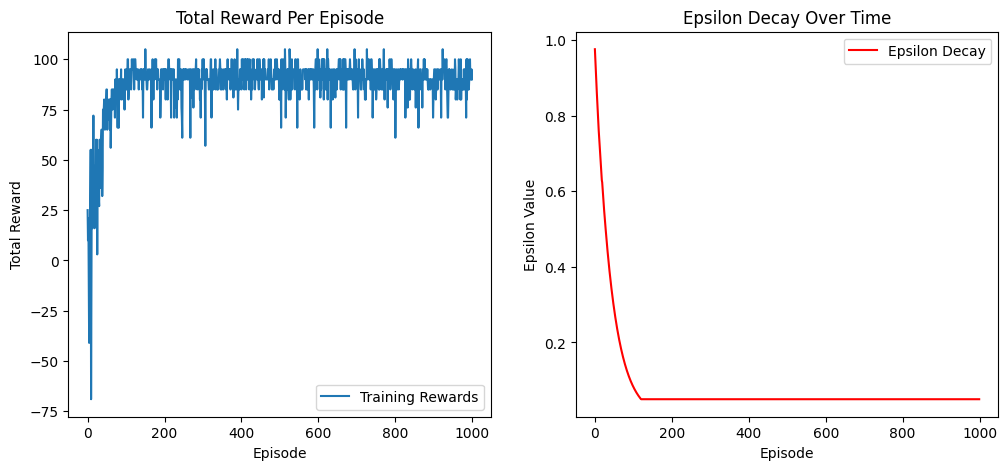

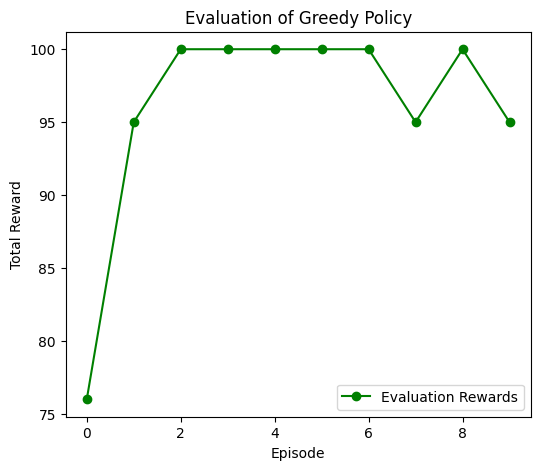

In [21]:
# gamma = 0.99, epsilon = 0.9995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 85
Episode 100/1000: Reward = 85
Episode 150/1000: Reward = 81
Episode 200/1000: Reward = 76
Episode 250/1000: Reward = 71
Episode 300/1000: Reward = 85
Episode 350/1000: Reward = 85
Episode 400/1000:

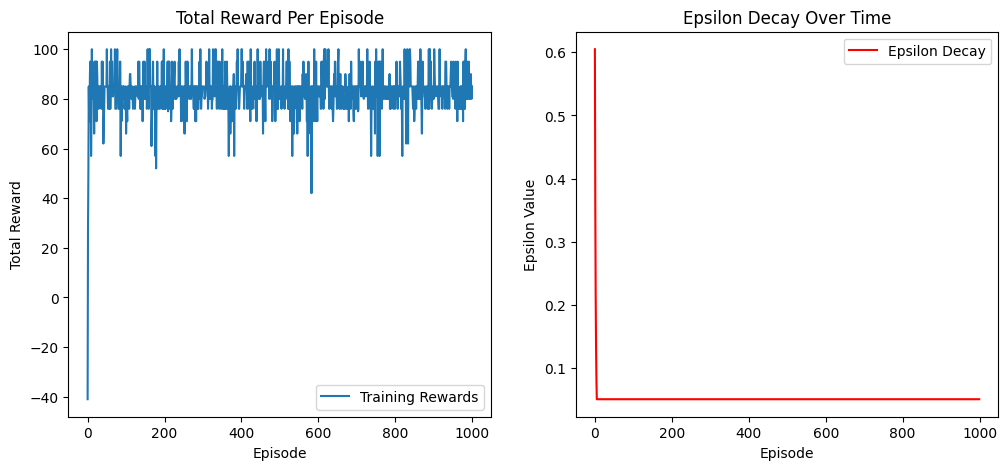

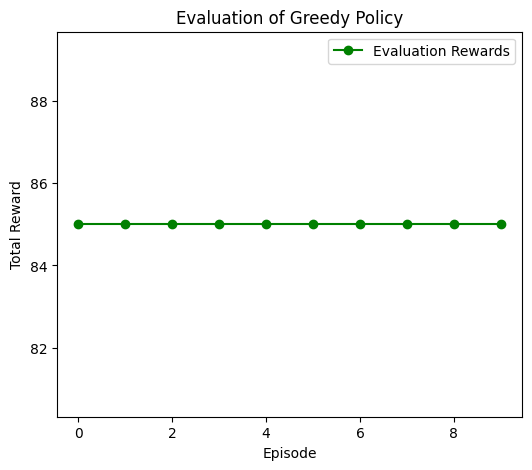

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 75
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 90
Episode 400/1000:

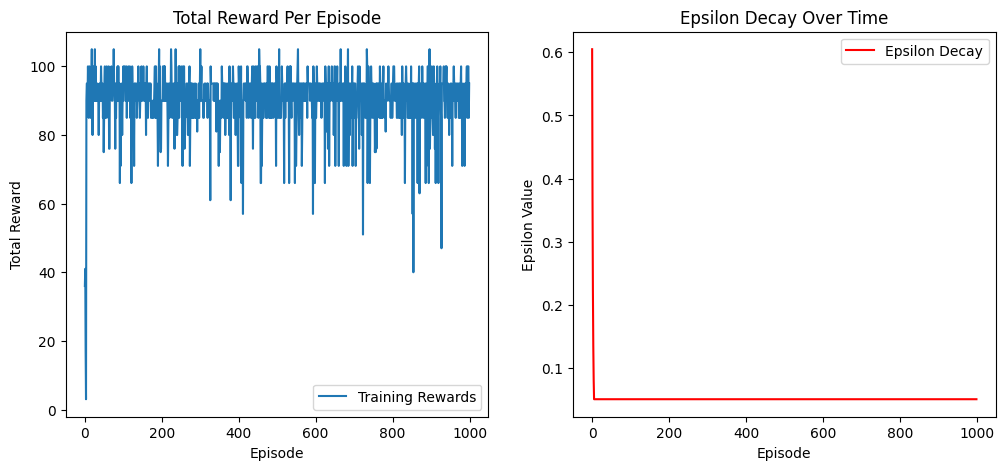

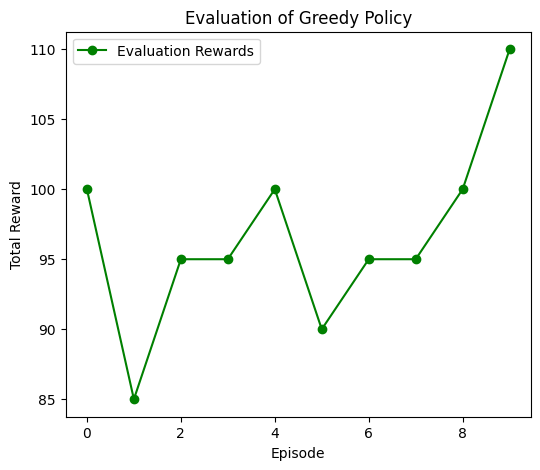

In [22]:
# gamma = 0.99, epsilon = 0.99

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

### Other Tabular Method - SARSA

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Trained Q-table:
[[ 5.59805383e+01  4.01661871e+01  5.13496018e+01  7.40187510e+01
   4.88142887e+01  5.79094105e+01]
 [ 6.24939556e+01  8.12675889e+01  4.21357413e+01  9.19838695e+00
   3.82067672e+01  5.35305386e+01]
 [ 0.00

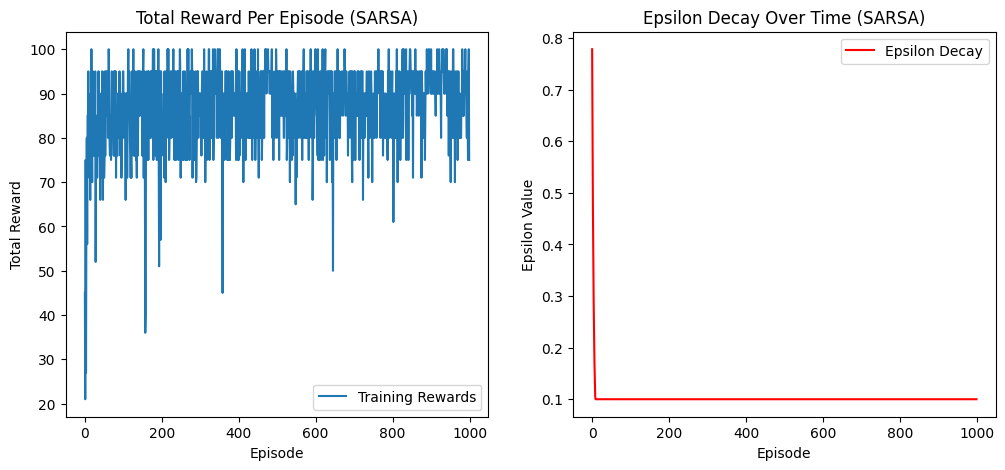

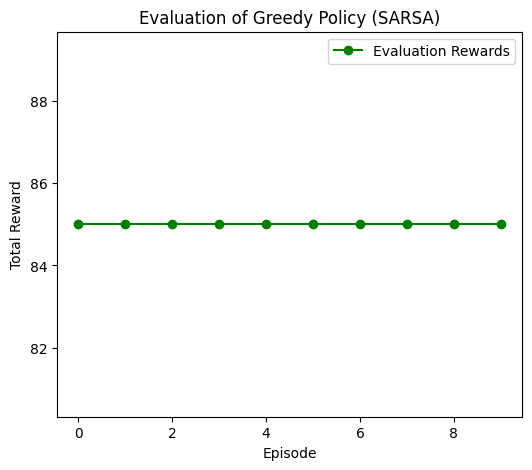

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Trained Q-table:
[[ 5.09659036e+01  3.07533857e+01  4.40298382e+01  8.27303715e+01
   4.61730413e+01  3.90048175e+01]
 [ 4.37195991e+01  8.69423616e+01  3.80763984e+01  2.46878055e+01
   4.29429728e+01  5.10694362e+01]
 [ 1.50

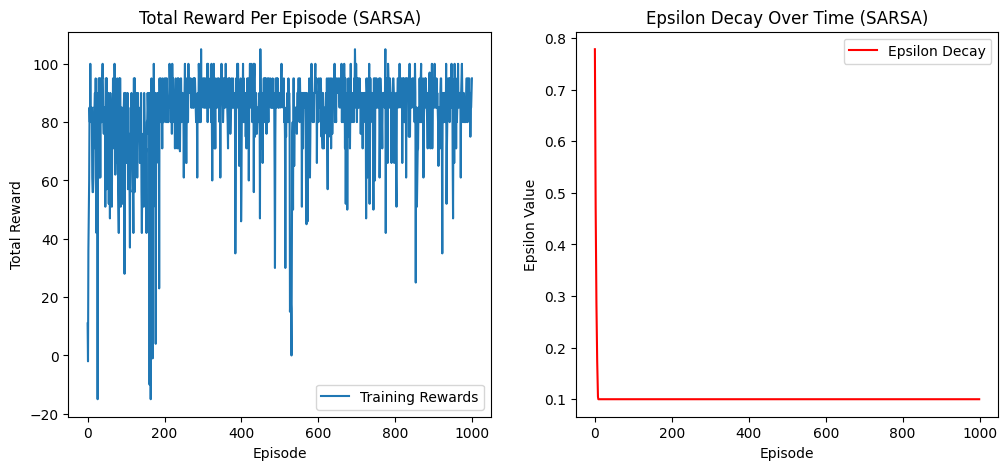

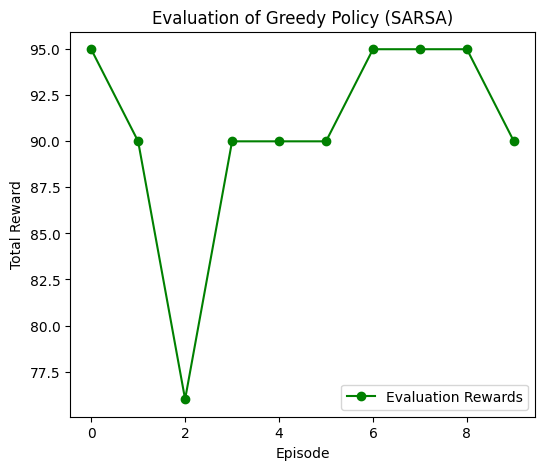

In [31]:
class SARSALearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.90, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.action_size)  # Random action (explore)
        return np.argmax(self.q_table[state])  # Best action (exploit)

    def update_q_table(self, state, action, reward, next_state, next_action):
        """Update Q-values using SARSA update rule"""
        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]
        self.q_table[state, action] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_q_table_pickle(self, filename):
        """Save Q-table as a pickle file"""
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table_pickle(self, filename):
        """Load Q-table from a pickle file"""
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)

    def save_q_table_h5(self, filename):
        """Save Q-table as an H5 file"""
        with h5py.File(filename, 'w') as f:
            f.create_dataset('q_table', data=self.q_table)

    def load_q_table_h5(self, filename):
        """Load Q-table from an H5 file"""
        with h5py.File(filename, 'r') as f:
            self.q_table = np.array(f['q_table'])


def train_sarsa(env, agent, num_episodes=500):
    rewards_per_episode = []
    epsilon_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        action = agent.choose_action(state_index)
        total_reward = 0

        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state_index = next_state[0] * env.grid_size + next_state[1]
            next_action = agent.choose_action(next_state_index)

            agent.update_q_table(state_index, action, reward, next_state_index, next_action)

            state_index = next_state_index
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon_values.append(agent.epsilon)

    return rewards_per_episode, epsilon_values


def evaluate_sarsa(env, agent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(agent.q_table[state_index])  # Greedy action
            state, reward, done, _ = env.step(action)
            state_index = state[0] * env.grid_size + state[1]
            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards


def plot_results(rewards, epsilon_values, evaluation_rewards):
    episodes = range(len(rewards))

    # Total Rewards per Episode
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward Per Episode (SARSA)")
    plt.legend()

    # Epsilon Decay
    plt.subplot(1, 2, 2)
    plt.plot(episodes, epsilon_values, label="Epsilon Decay", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Time (SARSA)")
    plt.legend()
    plt.show()

    # Evaluation Rewards
    plt.figure(figsize=(6, 5))
    plt.plot(range(len(evaluation_rewards)), evaluation_rewards, marker='o', label="Evaluation Rewards", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation of Greedy Policy (SARSA)")
    plt.legend()
    plt.show()


if __name__ == "__main__":
# Deterministic method
    env = DroneDeliveryEnv(deterministic=True)

    agent = SARSALearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_sarsa(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table_pickle("qtable_sarsa_deterministic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_sarsa(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

# Stochastic method
    env = DroneDeliveryEnv(deterministic=False)

    agent = SARSALearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_sarsa(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table_pickle("qtable_sarsa_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_sarsa(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)



## Part 3 - Solve Stock Trading Environment

In [24]:
import pandas as pd
file_path = '/content/drive/MyDrive/RL Dataset/NVDA.csv'
df = pd.read_csv(file_path)
df.head()

Date    Open       High     Low   Close  Adj Close     Volume
0  2022-07-01  14.899  15.063000  14.392  14.523  14.506663  577610000
1  2022-07-05  14.175  14.971000  14.055  14.964  14.947166  651397000
2  2022-07-06  15.010  15.319000  14.789  15.130  15.112980  529066000
3  2022-07-07  15.456  15.945000  15.389  15.858  15.840160  492903000
4  2022-07-08  15.430  16.037001  15.389  15.838  15.820185  467972000

In [34]:
# Imports
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [35]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

         info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

Episode 100/1000, Total Reward: 3704.42136740149, Epsilon: 0.0100
Episode 200/1000, Total Reward: 60688.03646656635, Epsilon: 0.0100
Episode 300/1000, Total Reward: 41741.73490369282, Epsilon: 0.0100
Episode 400/1000, Total Reward: -654.672431313175, Epsilon: 0.0100
Episode 500/1000, Total Reward: 16004.755436373222, Epsilon: 0.0100
Episode 600/1000, Total Reward: -375.48367131240946, Epsilon: 0.0100
Episode 700/1000, Total Reward: -1312.9175853842792, Epsilon: 0.0100
Episode 800/1000, Total Reward: 251.83304390231598, Epsilon: 0.0100
Episode 900/1000, Total Reward: 40997.48915443407, Epsilon: 0.0100
Episode 1000/1000, Total Reward: 4243.286362036043, Epsilon: 0.0100


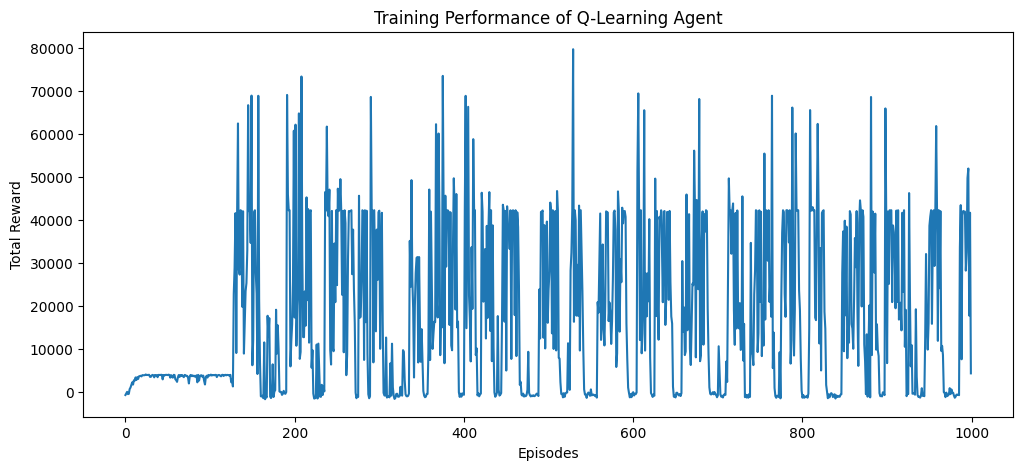

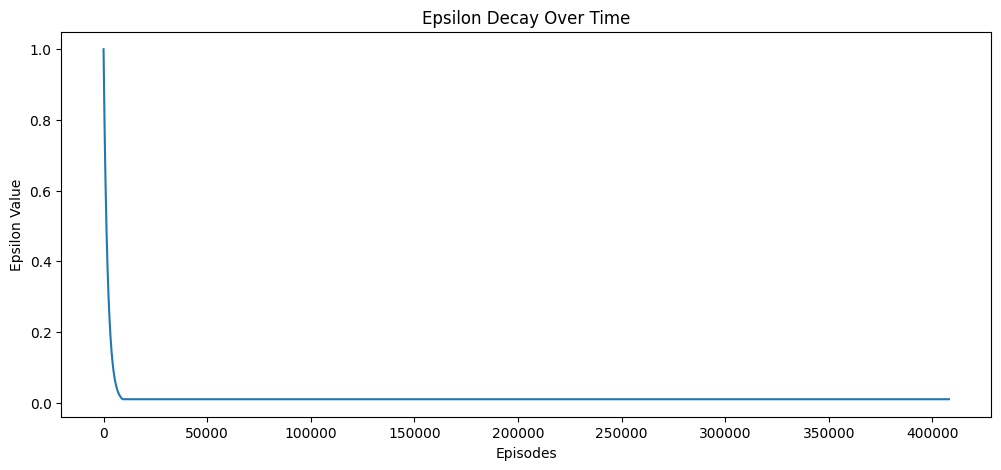

Total Reward after evaluation: 1983.7654158518335
Total Profit after evaluation: 29865.502299999993


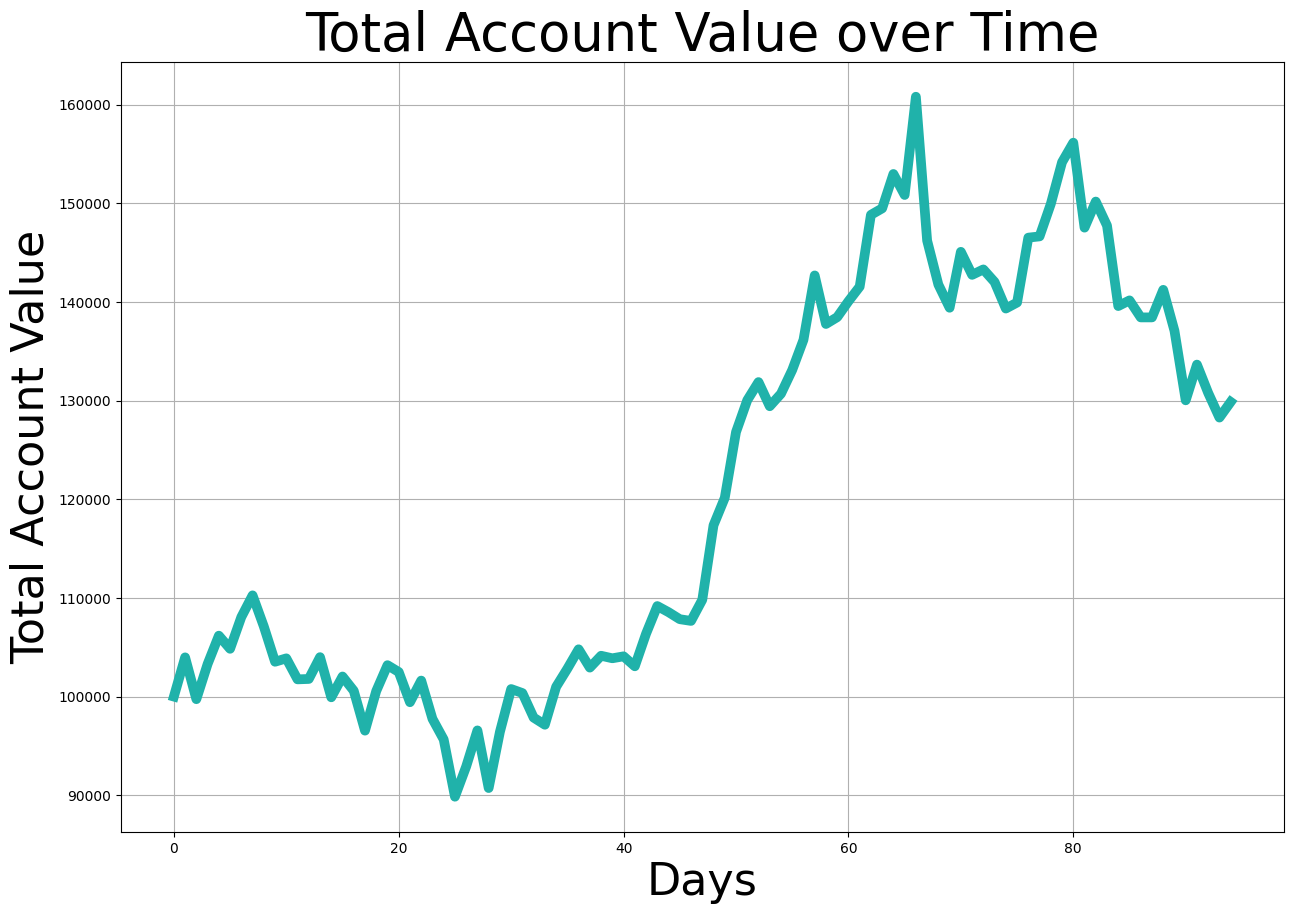

In [51]:
import numpy as np
import gymnasium as gym
import random
import pandas as pd
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995):
        """
        Initializes the Q-learning agent.
        :param state_size: Number of possible states in the environment.
        :param action_size: Number of possible actions the agent can take.
        :param alpha: Learning rate.
        :param gamma: Discount factor.
        :param epsilon: Initial exploration probability.
        :param epsilon_min: Minimum exploration probability.
        :param epsilon_decay: Decay rate of epsilon.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((state_size, action_size))  # Initialize Q-table
        self.epsilon_history = []


    def choose_action(self, state):
        """Chooses an action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))  # Explore
        else:
            return np.argmax(self.q_table[state, :])  # Exploit

    def learn(self, state, action, reward, next_state, done):
        """Updates the Q-table using the Q-learning update rule."""
        best_next_action = np.argmax(self.q_table[next_state, :])
        target = reward + (self.gamma * self.q_table[next_state, best_next_action] * (not done))
        self.q_table[state, action] += self.alpha * (target - self.q_table[state, action])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay epsilon
        self.epsilon_history.append(self.epsilon)


# Load the stock trading environment
env = StockTradingEnvironment(file_path=file_path, train=True)

# Define agent parameters
state_size = env.observation_space.n
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

# Training parameters
num_episodes = 1000  # Number of episodes for training
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

# Save the Q-table
with open("q_table_stock_trading.pkl", "wb") as f:
    pickle.dump(agent.q_table, f)

# Plot the rewards over episodes
plt.figure(figsize=(12, 5))
plt.plot(rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Performance of Q-Learning Agent")
plt.show()

# **Add the epsilon decay plot here**
plt.figure(figsize=(12, 5))
plt.plot(agent.epsilon_history)
plt.xlabel("Episodes")
plt.ylabel("Epsilon Value")
plt.title("Epsilon Decay Over Time")
plt.show()

# Evaluate the trained agent
env = StockTradingEnvironment(file_path=file_path, train=False)
state, _ = env.reset()
done = False
total_reward = 0

test_rewards = []
initial_capital = env.investment_capital

while not done:
    action = np.argmax(agent.q_table[state, :])  # Exploit learned policy
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward
    test_rewards.append(total_reward)

final_capital = env.total_account_value
total_profit = final_capital - initial_capital

print(f"Total Reward after evaluation: {total_reward}")
print(f"Total Profit after evaluation: {total_profit}")

env.render()
